## Research Question Tests

How is the misalia and tawasi characterized on the nawbas?

In [1]:
from music21 import *
import json
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
import pprint
from collections import Counter

## Misalia and taswasi annotation extraction

In [ ]:
! git clone https://github.com/MTG/arab-andalusian-music.git

In [2]:

annotations_file = './arab-andalusian-music/annotations/score-sections/arab-andalusian-scores-sections.csv'
sections = {}
sectionNames = ['mišālia','tawāšī']

with open (annotations_file, 'r', encoding='utf-8') as f:
    csv_reader = csv.reader(f, delimiter=',')
    headers = True
    for row in csv_reader:
        if headers:
            print(f'Column names are {", ".join(row)}')
            headers = False
        else:
            name = row[1]
            
            if not name in sectionNames:
                continue
            
            mbid = row[0]
            start = row[2]
            end = row[3]
            
            if not mbid in sections:    
                sections[mbid] = {}  
                
            if name not in sections[mbid]:
                sections[mbid][name] = []
            
            sections[mbid][name].append((start, end))

pprint.pprint(sections)

## Store in a JSON file to use it later on.
with open('misalia_tawasi_section_annotations_filtered.json', 'w') as outfile:
    json.dump(sections, outfile)

Column names are mbid, section, start, end
{'01da143e-4224-4692-8e6c-1d55f6de8a6d': {'mišālia': [('0.0', '118.5')],
                                          'tawāšī': [('120.5', '198.0')]},
 '023b4a37-1ab4-4593-b03a-850ee0db8350': {'mišālia': [('0.0', '163.0')],
                                          'tawāšī': [('166.0', '356.0')]},
 '02b76946-deec-48cf-9007-770c37b6c3cc': {'mišālia': [('0.0', '8.0'),
                                                      ('1515.0', '1636.0')]},
 '0386e377-7212-43e5-89b6-7f4c42d0ae74': {'mišālia': [('710.0', '926.0')],
                                          'tawāšī': [('1405.0', '1482.5')]},
 '03e555c6-a480-4e11-aef7-231891c4f4e6': {'mišālia': [('0.0', '140.0')]},
 '04b42450-8838-4a20-9e79-d42f03f8cc51': {'mišālia': [('0.0', '162.0')]},
 '07ee1daa-3bac-4bb8-922e-36729c11fc3a': {'mišālia': [('0.0', '44.0')],
                                          'tawāšī': [('108.0', '261.0')]},
 '095b5074-e93e-40a9-93a4-d90b48feda79': {'mišālia': [('0.0', '185

## Start the Extraction


In [4]:
##### VARIABLES SET UP ######

config = {
    'intervals': True,
    'pitch histogram': True,
    'centos': False
}

xml_scores_path = './arab-andalusian-music/scores-musicxml/'
final_intervals = {}
histogram = {}
centos = {}
centos_templates = {
    'C1': ['B-', 'A', 'G'],
    'C2': ['E', 'F', 'G'], 
    'C3': ['B', 'D', 'C'], 
    'C4': ['B', 'C'], 
    'C5': ['E','F','G','E','F','E','D','C'],
    'C6': ['G', 'F', 'E'], 
}

##### DEFINE FUNCTIONS #####

def extract_interval_from_note(n):
    return interval.Interval(n, n.next())

def extract_intervals(section_notes):
    intervals = {}
    for n in section_notes[:-1]:
        if not n.isNote or not n.next().isNote:
            continue
        
        itv = extract_interval_from_note(n)
        intervals[itv.name] = intervals.get(itv.name, 0) + 1

    return intervals

def is_centos_1(note):
    try:
        temp = [note.name, note.next().name, note.next().next().name]
    except:
        return False
    return centos_templates['C1'] == temp

def is_centos_2(note):
    try:
        temp = [note.name, note.next().name, note.next().next().name]
    except:
        return False
    return centos_templates['C2'] == temp

def is_centos_3(note):
    try:
        temp = [note.name, note.next().name, note.next().next().name]
    except:
        return False
    return centos_templates['C3'] == temp

def is_centos_4(note):
    try:
        temp = [note.name, note.next().name]
    except:
        return False
    return centos_templates['C4'] == temp

def is_centos_5(note):
    try:
        temp = [note.name, note.next().name, note.next().next().name, note.next().next().next().name, 
            note.next().next().next().next().name, note.next().next().next().next().next().name,
           note.next().next().next().next().next().next().name, note.next().next().next().next().next().next().next().name]
    except:
        return False
    
    return centos_templates['C5'] == temp

def is_centos_6(note):
    try:
        temp = [note.name, note.next().name, note.next().next().name]
    except:
        return False
            
    return centos_templates['C6'] == temp
    
##### START THE PARTY ######

for mbid in sections.keys():
    xml_file = '%s%s.xml' %(xml_scores_path, mbid)
    print('Loading %s%s.xml' %(xml_scores_path, mbid))
    if not os.path.exists(xml_file):
        print(xml_file + 'does not exist, file with no prefix, skipping....')
        continue
            
    s = converter.parse(xml_file)
    #get allnotes and rests
    nr = s.flat.notesAndRests.stream()
    scores = sections[mbid]
    ## For each misalia and tawasi in a mbid
    for sectionName, segments in scores.items():
        print('Analizing - %s' %sectionName)
        current_section = scores[sectionName]
        
        ## Each misalia or tawasi can have one or more sections with its start and end offsets
        for score_section in current_section:
            start = float(score_section[0])
            end = float(score_section[1])
            section_notes = nr.getElementsByOffset(start, end).stream()
            
            ##### INTERVALS RELATED
            if config['intervals']:
                
                if not mbid in final_intervals:
                    final_intervals.update({mbid:{}})

                if not sectionName in final_intervals[mbid]:
                    final_intervals[mbid].update({sectionName:{}})

                final_intervals[mbid][sectionName].update(extract_intervals(section_notes))
                
            ## PITCH HISTOGRAM (ask for wich note duration is the best)
            if config['pitch histogram']:
                for n in section_notes[:-1]:
                    if not n.isNote or not n.next().isNote:
                        continue
                    if not mbid in histogram:
                        histogram.update({mbid:{}})

                    if not sectionName in histogram[mbid]:
                        histogram[mbid].update({sectionName:{}})

                    note_name = n.nameWithOctave
                    note_duration = n.duration.quarterLength
                    #print(note_duration)
                    histogram[mbid][sectionName].update({
                        note_name: histogram[mbid][sectionName].get(note_name, 0) + note_duration
                    })
    
            ## CENTOS
            if config['centos']:
                print('centos')
                
                '''for n in section_notes[:-1]:
                    if not n.isNote:
                        continue

                    if not mbid in centos:
                        centos.update({mbid:{}})

                    if not sectionName in centos[mbid]:
                        centos[mbid].update({sectionName:{}})
                    #print('note:%s , next: %s, nextnext:%s'%(n.name, n.next().name, n.next().next().name))
                    #print(is_centos_1(n))
                    if is_centos_1(n):
                        centos[mbid][sectionName].update({'C1': centos[mbid][sectionName].get('C1', 0) + 1})

                    if is_centos_2(n):
                        centos[mbid][sectionName].update({'C2': centos[mbid][sectionName].get('C2', 0) + 1})

                    if is_centos_3(n):
                        #print('note:%s , next: %s, nextnext:%s'%(n.name, n.next().name, n.next().next().name))
                        centos[mbid][sectionName].update({'C3': centos[mbid][sectionName].get('C3', 0) + 1})

                    if is_centos_4(n):
                        centos[mbid][sectionName].update({'C4': centos[mbid][sectionName].get('C4', 0) + 1})

                    if is_centos_5(n):
                        centos[mbid][sectionName].update({'C5': centos[mbid][sectionName].get('C5', 0) + 1})

                    if is_centos_6(n):
                        #print('note:%s , next: %s, nextnext:%s'%(n.name, n.next().name, n.next().next().name))
                        centos[mbid][sectionName].update({'C6': centos[mbid][sectionName].get('C6', 0) + 1})
                        '''
                        


## Store intervals for each mbid
with open('misalia_tawasi_intervals_by_mbid.json', 'w') as outfile:
    json.dump(final_intervals, outfile)

## Store Note duration for each mbid
with open('misalia_tawasi_duration_histogram_by_mbid_octave.json', 'w') as outfile:
    json.dump(histogram, outfile)
    
## Store Note duration for each mbid
with open('misalia_tawasi_centos_counter_by_mbid.json', 'w') as outfile:
    json.dump(centos, outfile)
    
#pprint.pprint(histogram)
#pprint.pprint(final_intervals)
#pprint.pprint(centos)

Loading ./arab-andalusian-music/scores-musicxml/01da143e-4224-4692-8e6c-1d55f6de8a6d.xml
Analizing - mišālia
Analizing - tawāšī
Loading ./arab-andalusian-music/scores-musicxml/023b4a37-1ab4-4593-b03a-850ee0db8350.xml
Analizing - mišālia
Analizing - tawāšī
Loading ./arab-andalusian-music/scores-musicxml/02b76946-deec-48cf-9007-770c37b6c3cc.xml
Analizing - mišālia
Loading ./arab-andalusian-music/scores-musicxml/0386e377-7212-43e5-89b6-7f4c42d0ae74.xml
Analizing - mišālia
Analizing - tawāšī
Loading ./arab-andalusian-music/scores-musicxml/03e555c6-a480-4e11-aef7-231891c4f4e6.xml
Analizing - mišālia
Loading ./arab-andalusian-music/scores-musicxml/04b42450-8838-4a20-9e79-d42f03f8cc51.xml
Analizing - mišālia
Loading ./arab-andalusian-music/scores-musicxml/07ee1daa-3bac-4bb8-922e-36729c11fc3a.xml
Analizing - mišālia
Analizing - tawāšī
Loading ./arab-andalusian-music/scores-musicxml/095b5074-e93e-40a9-93a4-d90b48feda79.xml
Analizing - mišālia
Analizing - tawāšī
Loading ./arab-andalusian-music/s

Analizing - mišālia
Loading ./arab-andalusian-music/scores-musicxml/8ddaae6b-3657-41f1-98a1-7faffd6dcb5f.xml
Analizing - mišālia
Analizing - tawāšī
Loading ./arab-andalusian-music/scores-musicxml/92de6fc8-a040-4500-bd94-73e9ee39f189.xml
Analizing - mišālia
Analizing - tawāšī
Loading ./arab-andalusian-music/scores-musicxml/95940501-39f3-4c08-9bbb-1799d8d89a45.xml
Analizing - mišālia
Analizing - tawāšī
Loading ./arab-andalusian-music/scores-musicxml/97223154-d5c2-4c37-8e6c-4c998056a674.xml
Analizing - mišālia
Loading ./arab-andalusian-music/scores-musicxml/9727ddbe-eb79-461b-9861-8a60336b17f6.xml
Analizing - mišālia
Analizing - tawāšī
Loading ./arab-andalusian-music/scores-musicxml/9781e524-92de-43f2-87e3-1e9f05931f0e.xml
Analizing - mišālia
Loading ./arab-andalusian-music/scores-musicxml/99004770-1152-4fec-802a-a0014e9b9930.xml
Analizing - mišālia
Analizing - tawāšī
Loading ./arab-andalusian-music/scores-musicxml/99c711e8-0683-4a44-9116-fc2b9448d98d.xml
Analizing - mišālia
Loading ./ara

                                                     'B3': 9.5,
                                                     'C4': 48.5,
                                                     'D4': 41.0,
                                                     'E4': 29.0,
                                                     'F4': 27.0,
                                                     'G3': 1.0,
                                                     'G4': 34.0}},
 '47a41543-89c7-40ad-a665-f7460ad4e4de': {'mišālia': {'A4': 1.0,
                                                      'B-4': 0.5,
                                                      'B3': 0.5,
                                                      'C4': 1.5,
                                                      'D4': 1.0,
                                                      'E4': 3.5,
                                                      'F4': 5.5,
                                                      'G4': 5.5}},
 '47e023e5-62a3-4dec-b

 '9b194c42-f974-42f8-89b1-123bb07170b8': {'mišālia': {'A3': 1.5,
                                                      'A4': 1.5,
                                                      'B-4': 0.75,
                                                      'B3': 9.75,
                                                      'C4': 7.0,
                                                      'D4': 7.75,
                                                      'E4': 17.0,
                                                      'F4': 9.75,
                                                      'G3': 2.5,
                                                      'G4': 6.0}},
 '9b546274-eea6-459f-a0c2-918f0997fa2b': {'mišālia': {'A3': 2.25,
                                                      'A4': 9.0,
                                                      'B3': 2.75,
                                                      'C4': 10.25,
                                                      'D4': 9.75,
            

## PITCH Histogram (Duration of notes)

In [2]:
def read_histogram_file():
    with open('misalia_tawasi_duration_histogram_by_mbid_octave.json', 'r') as outfile:
        histogram = json.load(outfile)
    return histogram
 
#if not histogram:
histogram = read_histogram_file()

    
with open('mbid_nawba.json', 'r') as mapping:
    nawbas_mapping = json.load(mapping)
    
sectionNames = ['mišālia','tawāšī']
    

In [3]:
# Grouping by nawbas
nawba_grouped = {}
print(len(histogram))
for mbid in histogram:
    if not nawbas_mapping[mbid] in nawba_grouped:
        nawba_grouped[nawbas_mapping[mbid]] = {}
        #{'al maya': {'hhjf-dfdf-df': {misalia:{}, tawasi:{}}}
        
    if not mbid in nawba_grouped[nawbas_mapping[mbid]]:
        nawba_grouped[nawbas_mapping[mbid]][mbid] = {}
        
    if sectionNames[0] in histogram[mbid]:
        if not sectionNames[0] in nawba_grouped[nawbas_mapping[mbid]][mbid]:
            nawba_grouped[nawbas_mapping[mbid]][mbid][sectionNames[0]] = {}
     
        nawba_grouped[nawbas_mapping[mbid]][mbid].update(
            {
                sectionNames[0]: histogram[mbid][sectionNames[0]]
            }
        )
    if sectionNames[1] in histogram[mbid]:
        if not sectionNames[1] in nawba_grouped[nawbas_mapping[mbid]][mbid]:
            nawba_grouped[nawbas_mapping[mbid]][mbid][sectionNames[1]] = {}
        nawba_grouped[nawbas_mapping[mbid]][mbid].update(
            {
                sectionNames[1]: histogram[mbid][sectionNames[1]]
            }
        )
#print(len(nawba_grouped))        
#pprint.pprint(nawba_grouped)

with open('mbids_grouped_by_nawba_octave_and_midi.json', 'w') as outfile:
    json.dump(nawba_grouped, outfile)
        
        
    

116
11
{'al-istihlāl': {'023b4a37-1ab4-4593-b03a-850ee0db8350': {'mišālia': {'A3': 2.25,
                                                                      'A4': 7.5,
                                                                      'B3': 2.75,
                                                                      'C4': 10.25,
                                                                      'D4': 9.75,
                                                                      'E4': 15.5,
                                                                      'F4': 21.75,
                                                                      'G3': 1.0,
                                                                      'G4': 18.25},
                                                          'tawāšī': {'A3': 11.0,
                                                                     'A4': 6.5,
                                                                     'B-4': 0.5,
           

                                                                              'D5': 36.0,
                                                                              'E4': 371.75,
                                                                              'E5': 9.75,
                                                                              'F#4': 3.0,
                                                                              'F4': 811.0,
                                                                              'F5': 4.5,
                                                                              'G4': 523.0}},
                         '7e3ee6f2-c42f-4da4-9816-45aadcffea88': {'mišālia': {'A4': 14.5,
                                                                              'B-4': 1.5,
                                                                              'B4': 1.5,
                                                                              'C4': 6.75,
      

                                                                      'E4': 4.25,
                                                                      'F4': 0.25,
                                                                      'G3': 0.5,
                                                                      'G4': 1.75}},
                  '8a7aa258-312b-4bfb-8b00-a58c925ceae2': {'mišālia': {'A3': 1.0,
                                                                       'A4': 12.0,
                                                                       'B-4': 1.0,
                                                                       'B3': 1.0,
                                                                       'C4': 3.0,
                                                                       'D4': 9.5,
                                                                       'E4': 24.0,
                                                                       'F4': 6.5,
            

In [4]:
## Only get One Misalia and Tawasi pitch histogram by nawba
nawba_synthetised = {}
for nawba in nawba_grouped:
    if not nawba in nawba_synthetised:
        nawba_synthetised[nawba] = {}
    for mbid in nawba_grouped[nawba]:
        for section in nawba_grouped[nawba][mbid]:
            if nawba_grouped[nawba][mbid][section]:
                if not section in  nawba_synthetised[nawba]:
                    nawba_synthetised[nawba][section] = {}
                ## Sum dictionaries - 
                nawba_synthetised[nawba][section] = dict(Counter(nawba_grouped[nawba][mbid][section]) + Counter(nawba_synthetised[nawba][section]))
                #print(section)
                
pprint.pprint(nawba_synthetised)
                
    

{'al-istihlāl': {'mišālia': {'A3': 212.25,
                             'A4': 595.75,
                             'B-4': 16.0,
                             'B3': 247.75,
                             'B4': 25.5,
                             'C4': 1082.5,
                             'C5': 57.0,
                             'D4': 867.25,
                             'D5': 6.75,
                             'E4': 1212.5,
                             'E5': 1.5,
                             'F4': 897.75,
                             'F5': 1.5,
                             'G3': 79.0,
                             'G4': 1018.5},
                 'tawāšī': {'A3': 260.5,
                            'A4': 236.5,
                            'B-4': 2.5,
                            'B3': 292.5,
                            'B4': 36.0,
                            'C4': 515.5,
                            'C5': 24.0,
                            'D4': 736.75,
                            'E4': 813.25,
 

## Plotting Pitch Histogram

--------
Plotting..‘irāq al-‘aŷam
--------
Plotting..al-istihlāl
--------
Plotting..al-raṣd
--------
Plotting..raṣd al-ḏāyl
--------
Plotting..al-iṣbahān
--------
Plotting..al-‘uššāq
--------
Plotting..al-ḥiŷāz al-kabīr
--------
Plotting..al-māya
--------
Plotting..raml al-māya
--------
Plotting..al-ḥiŷāz al-mašriqī
--------
Plotting..garībat al-ḥusayn


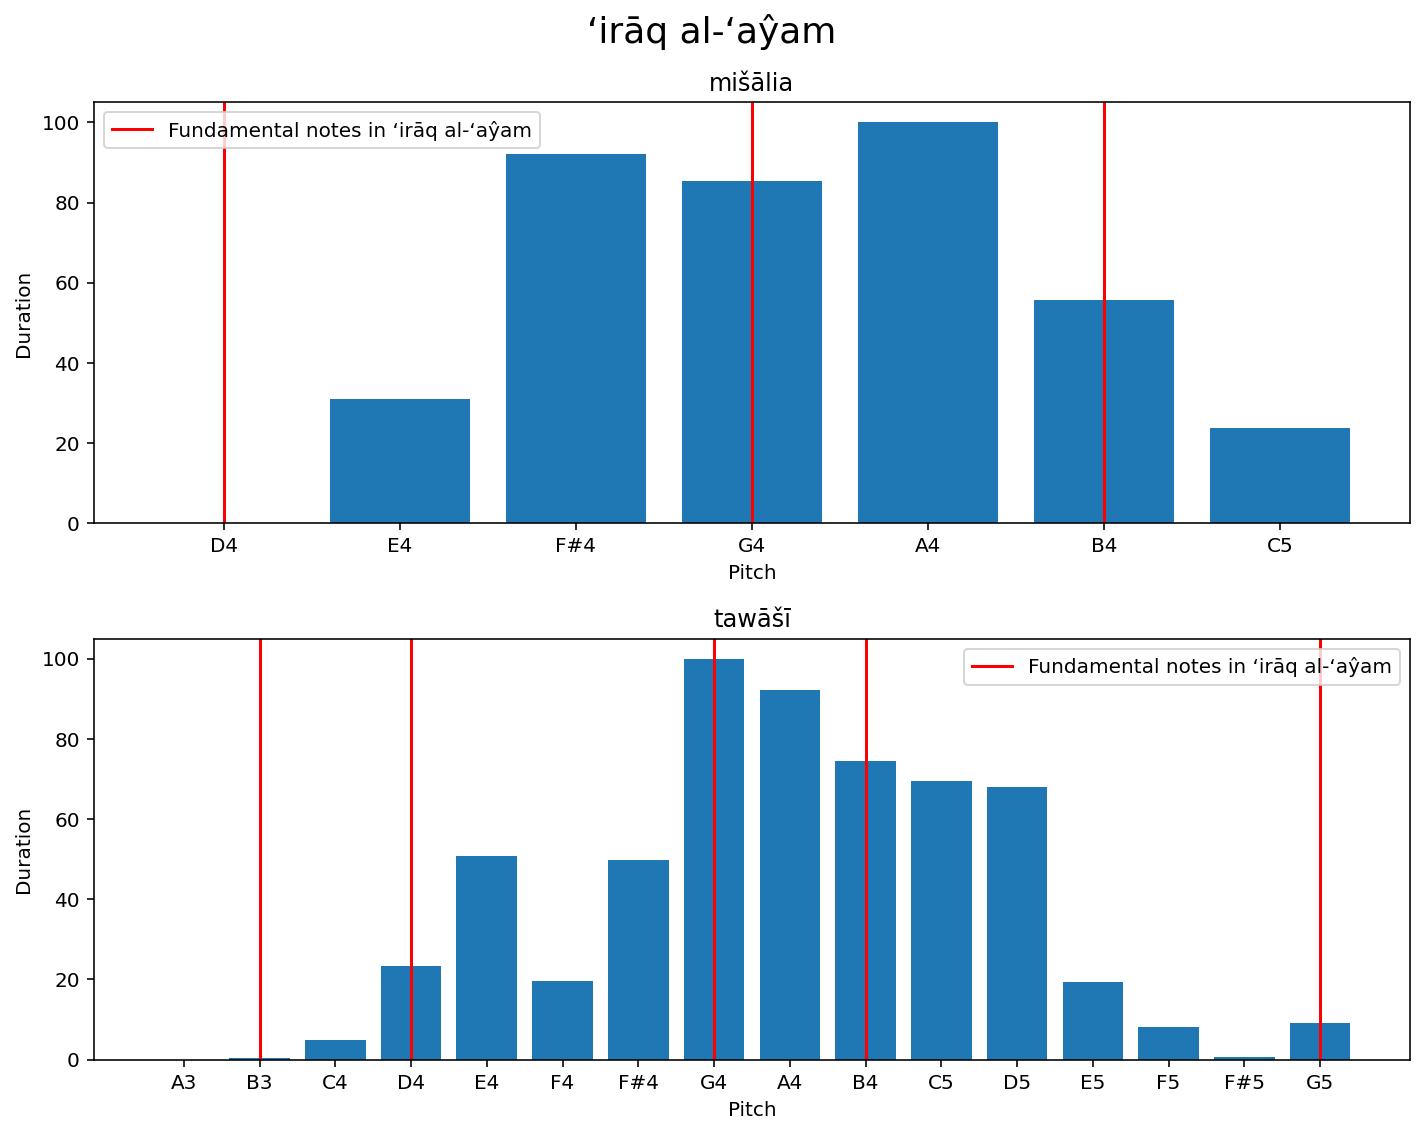

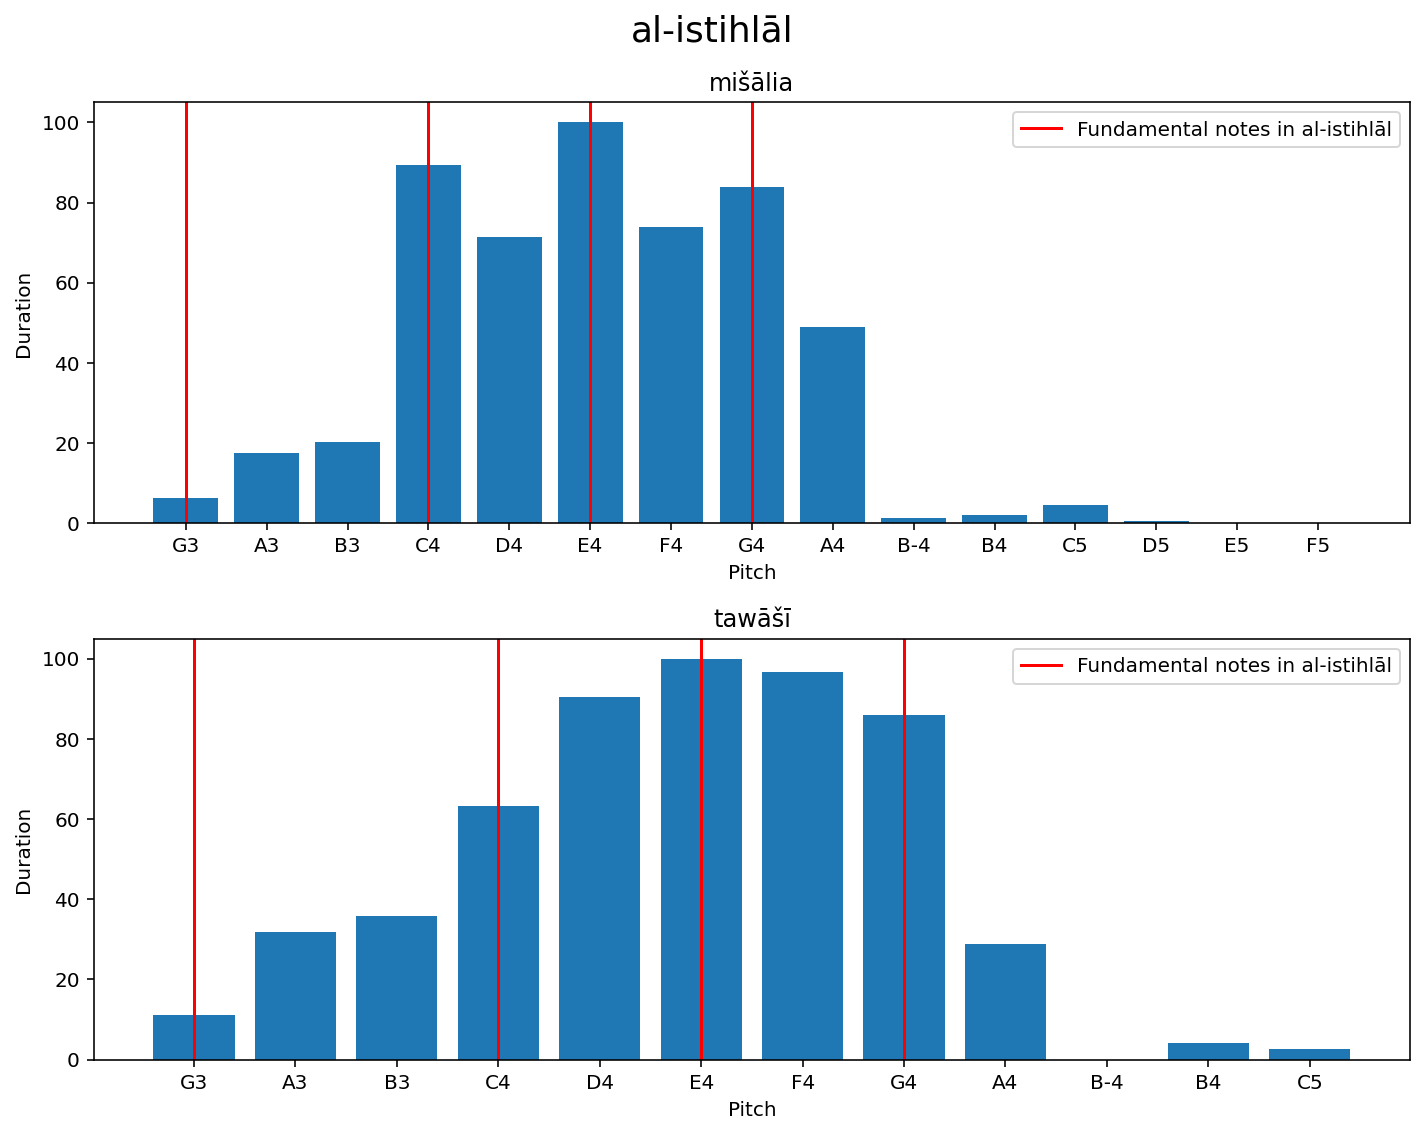

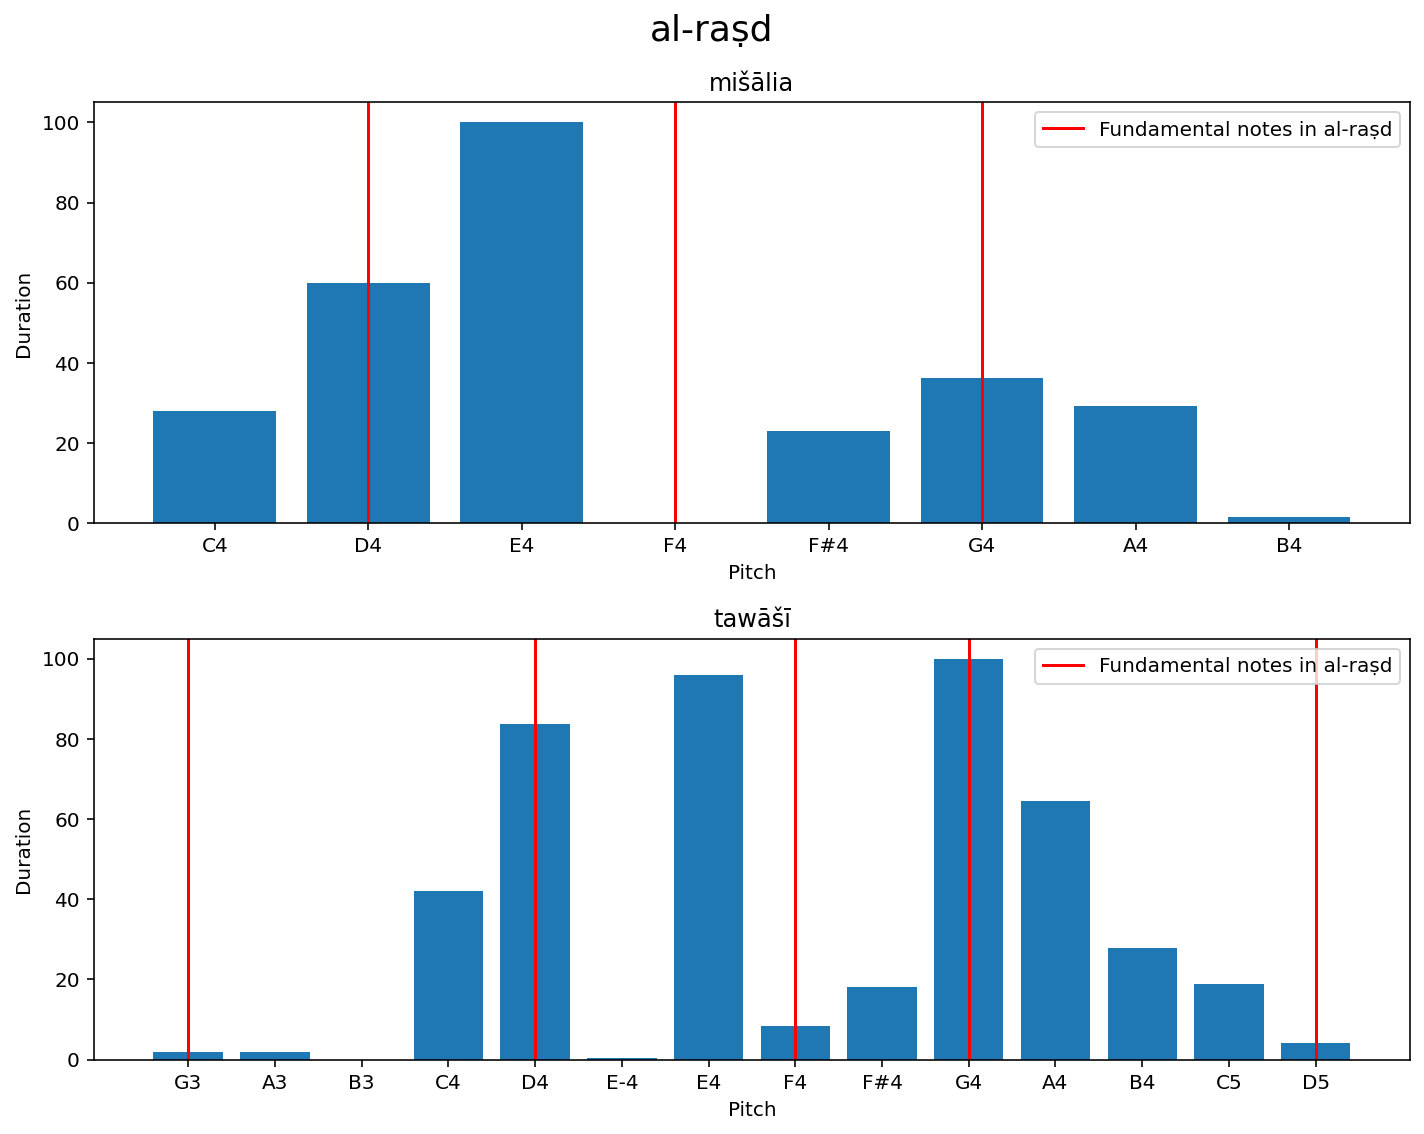

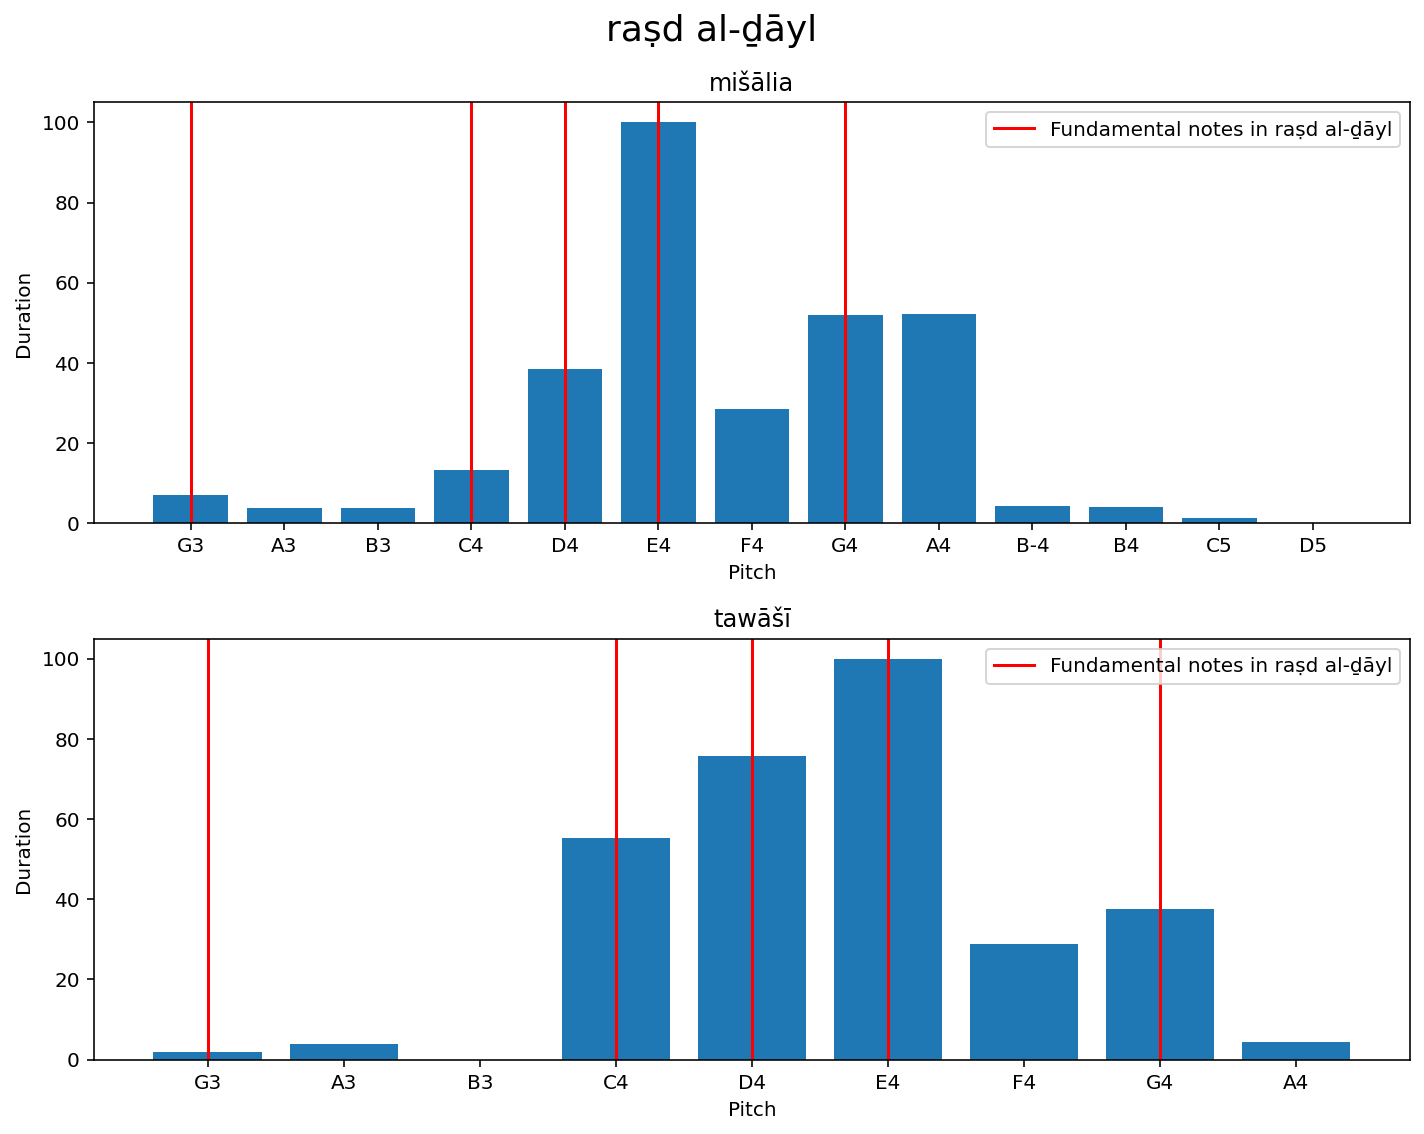

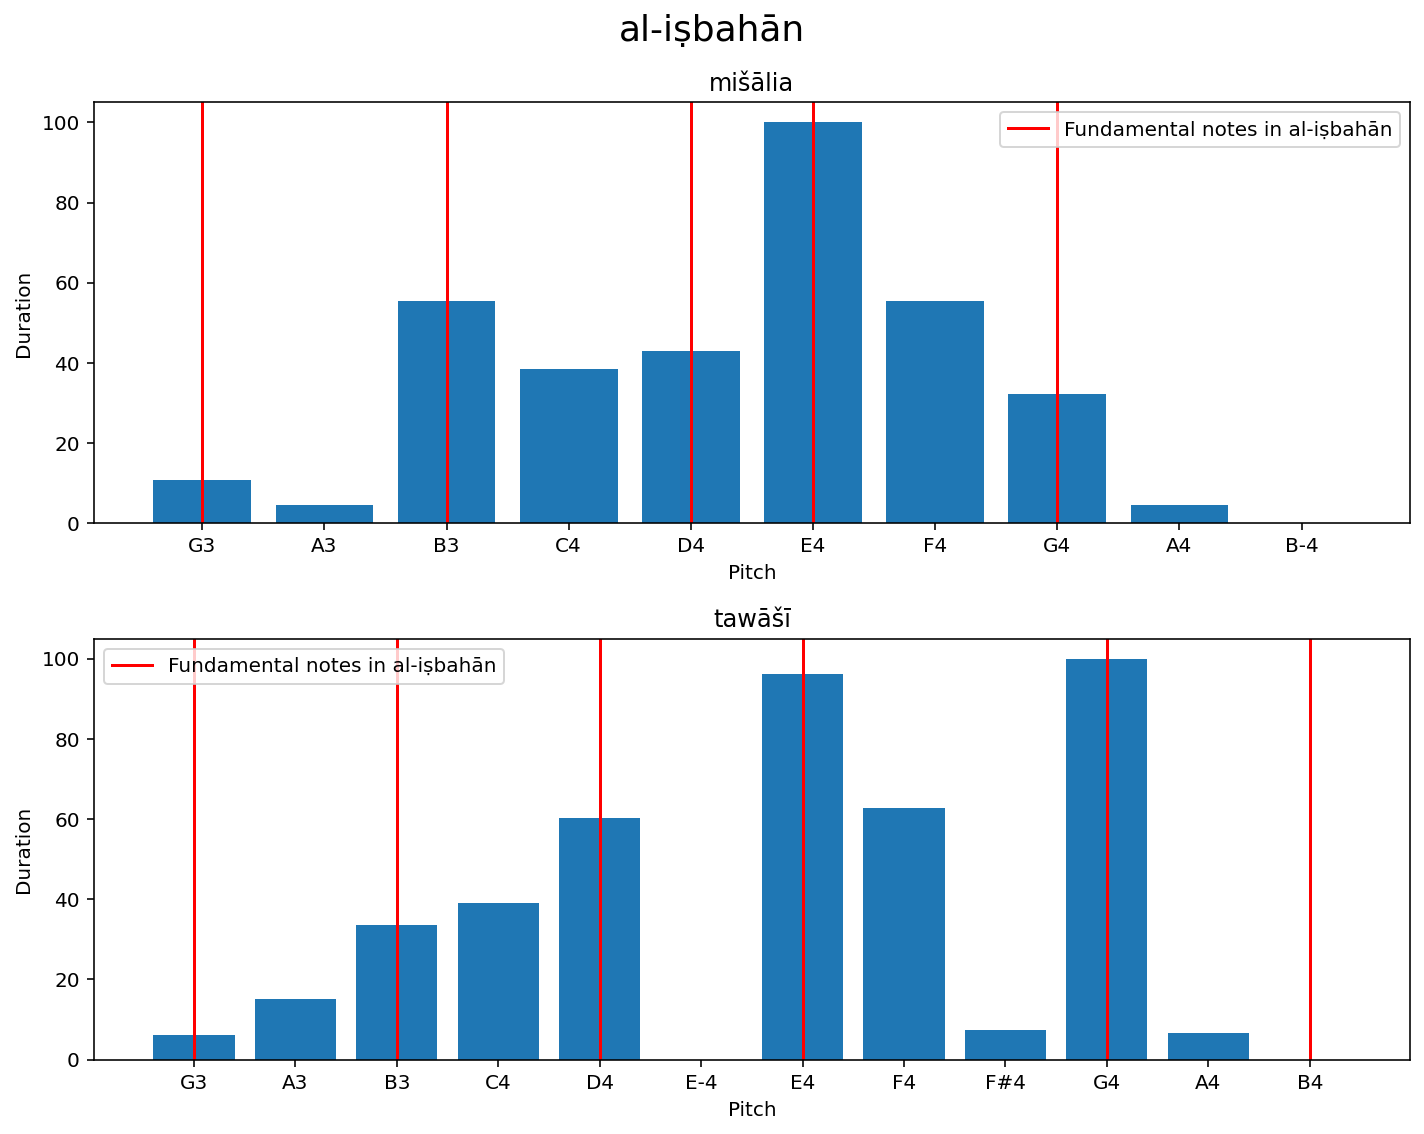

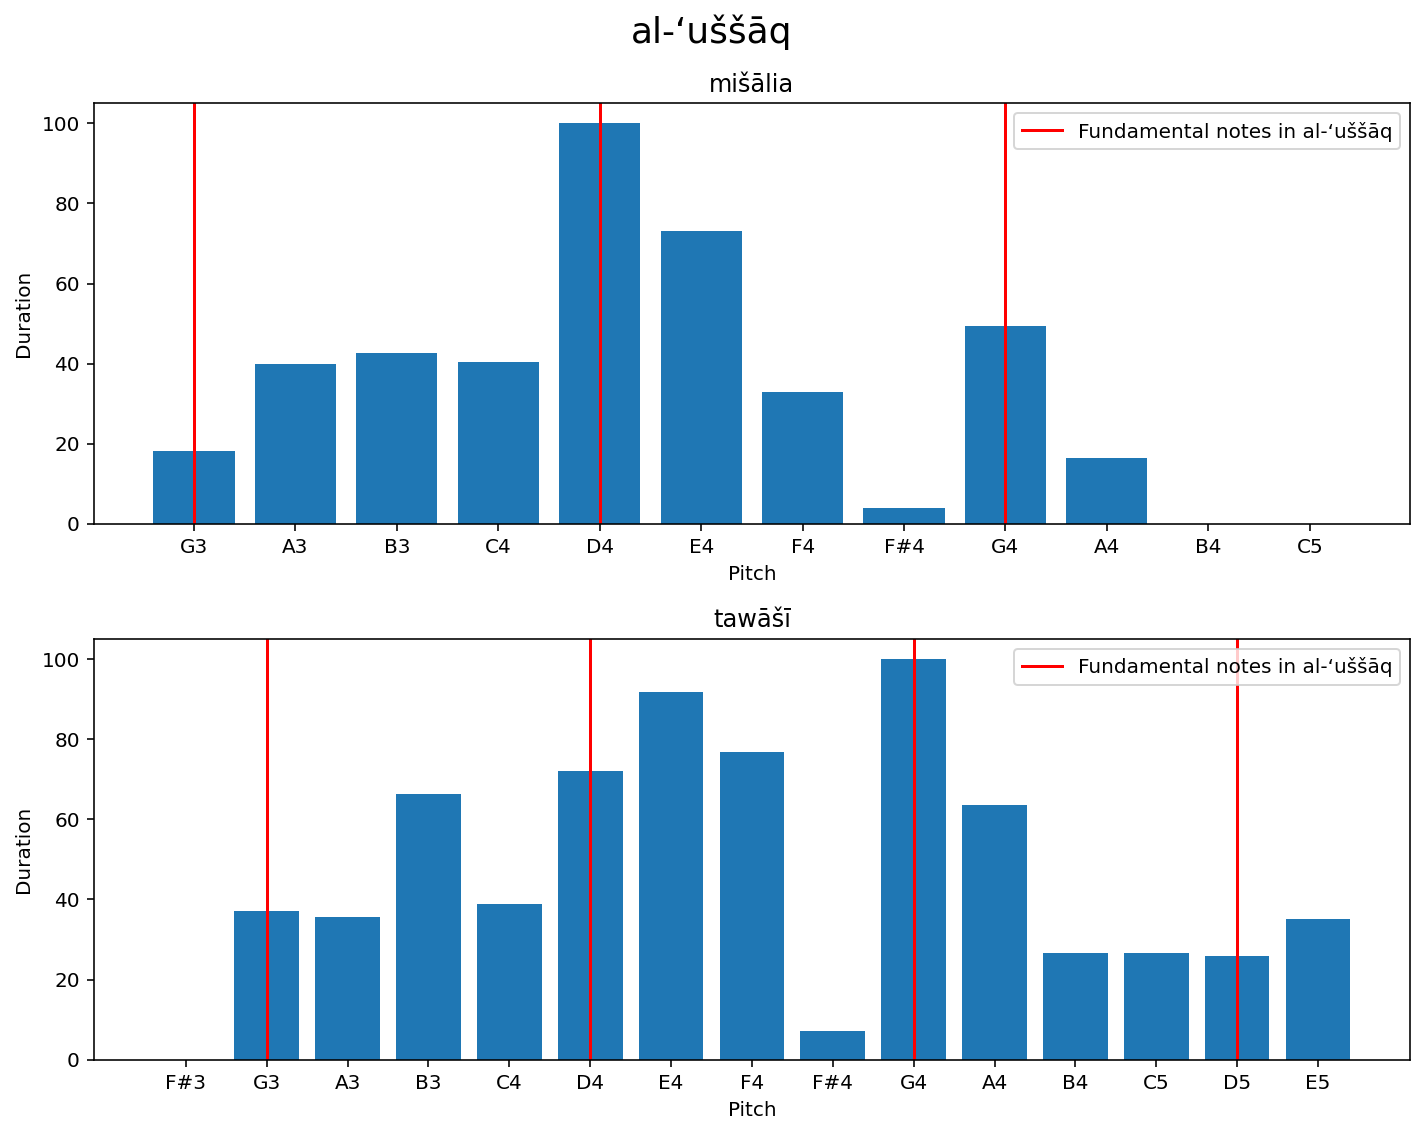

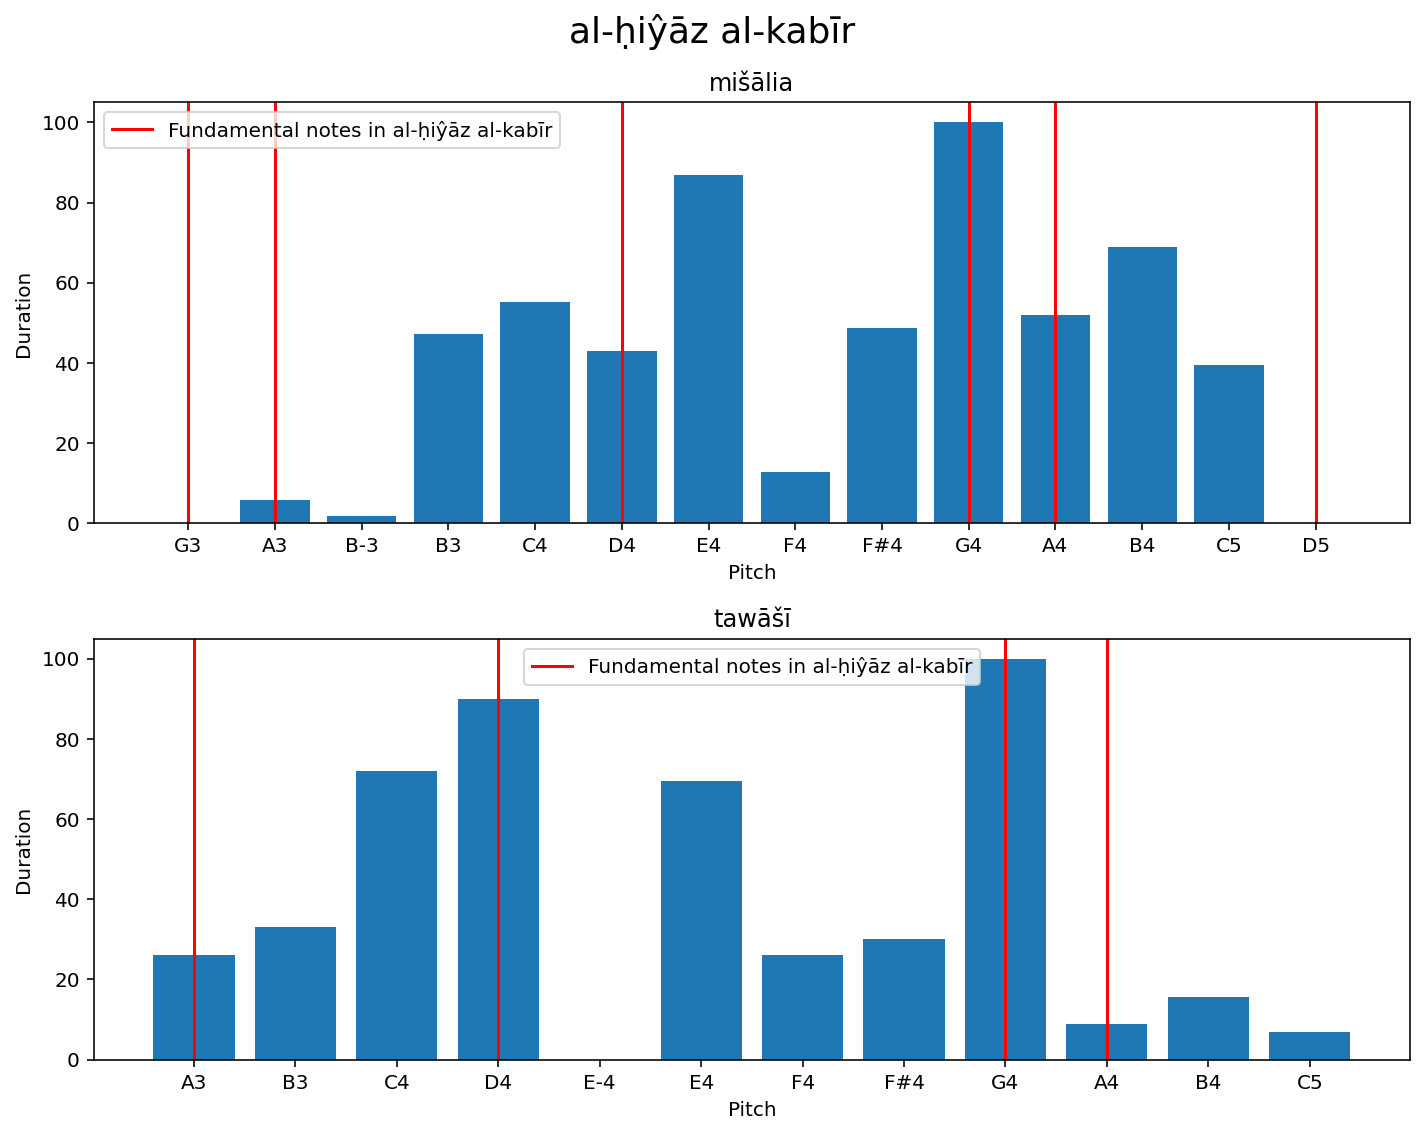

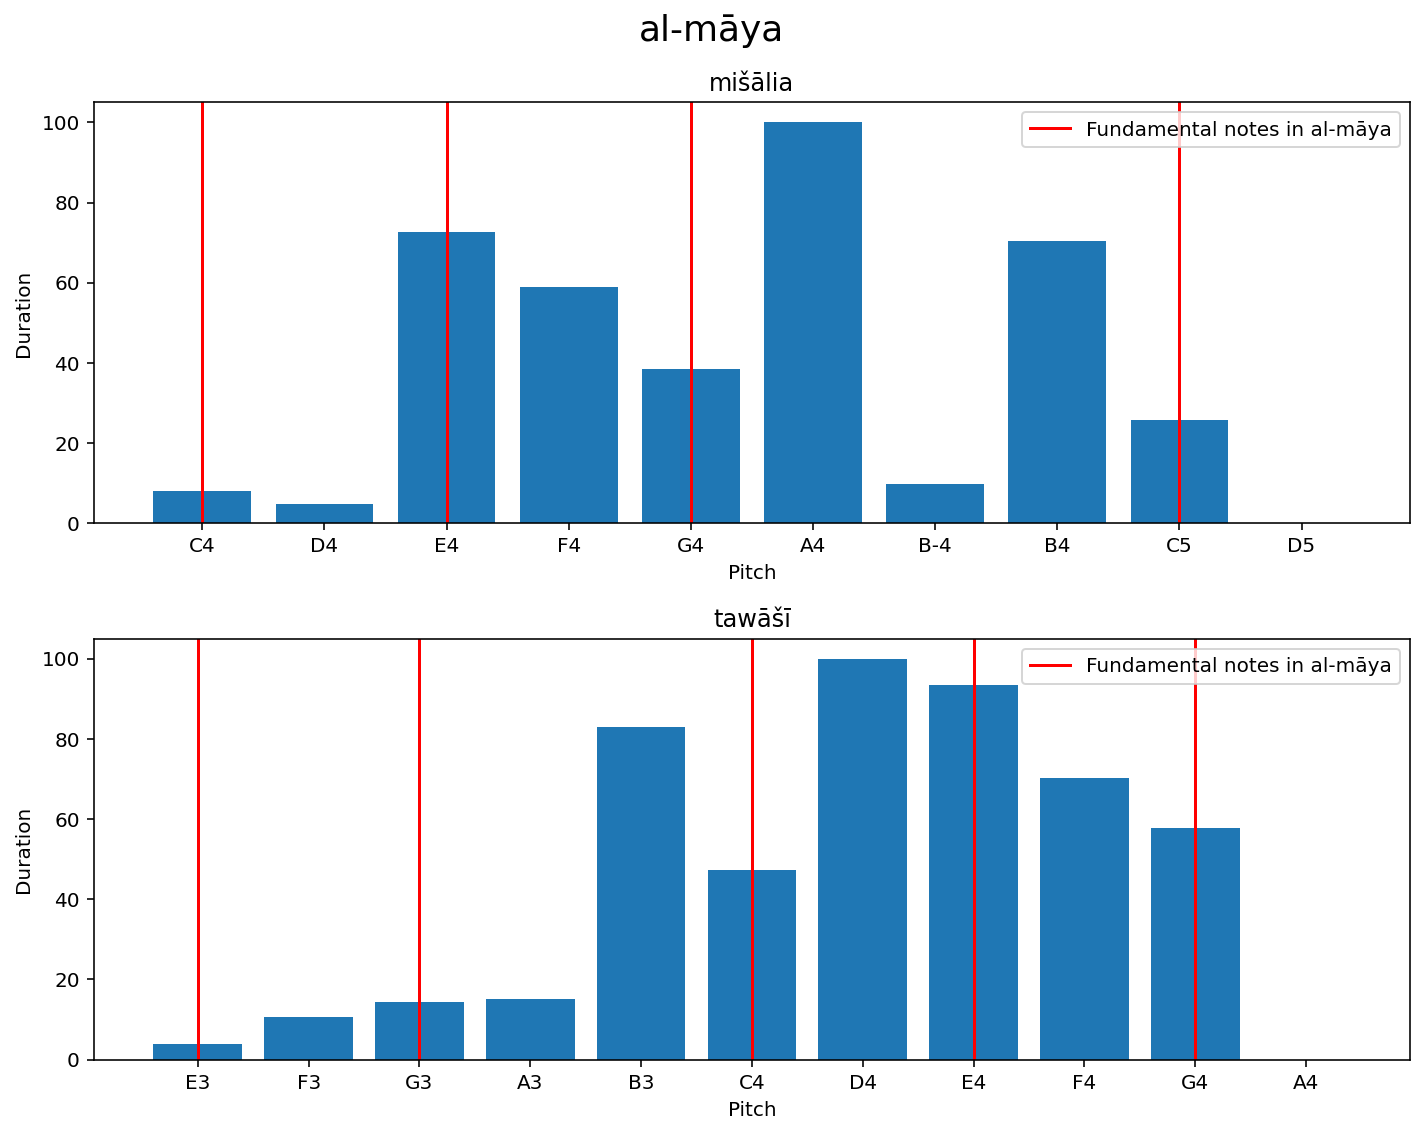

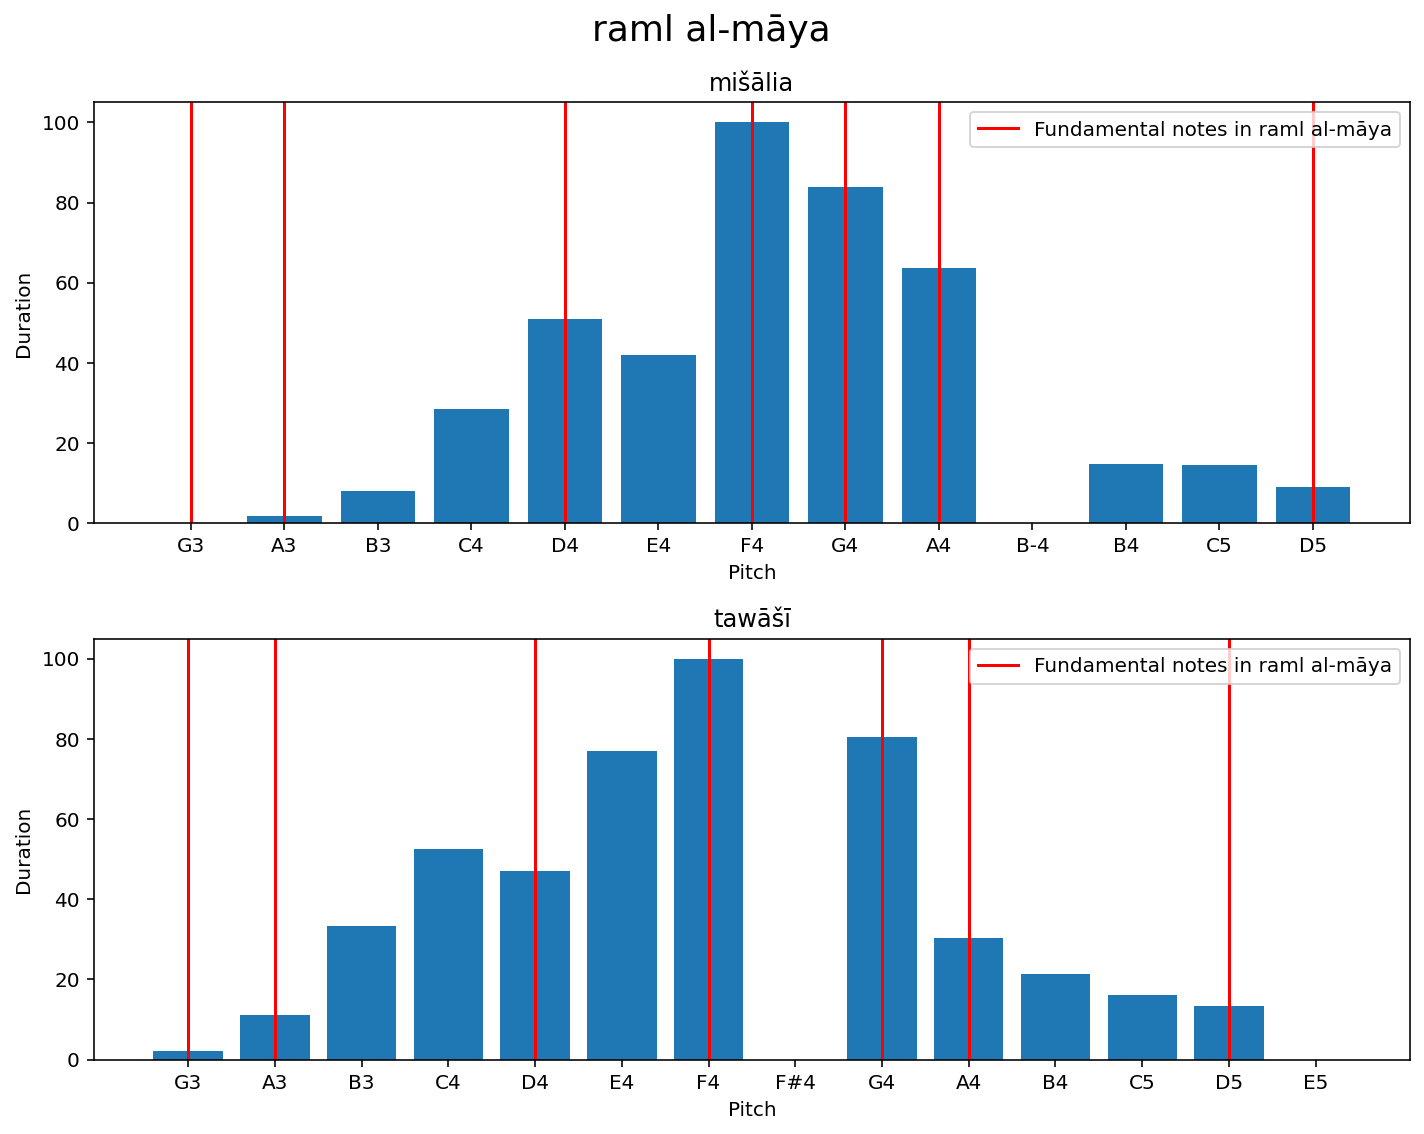

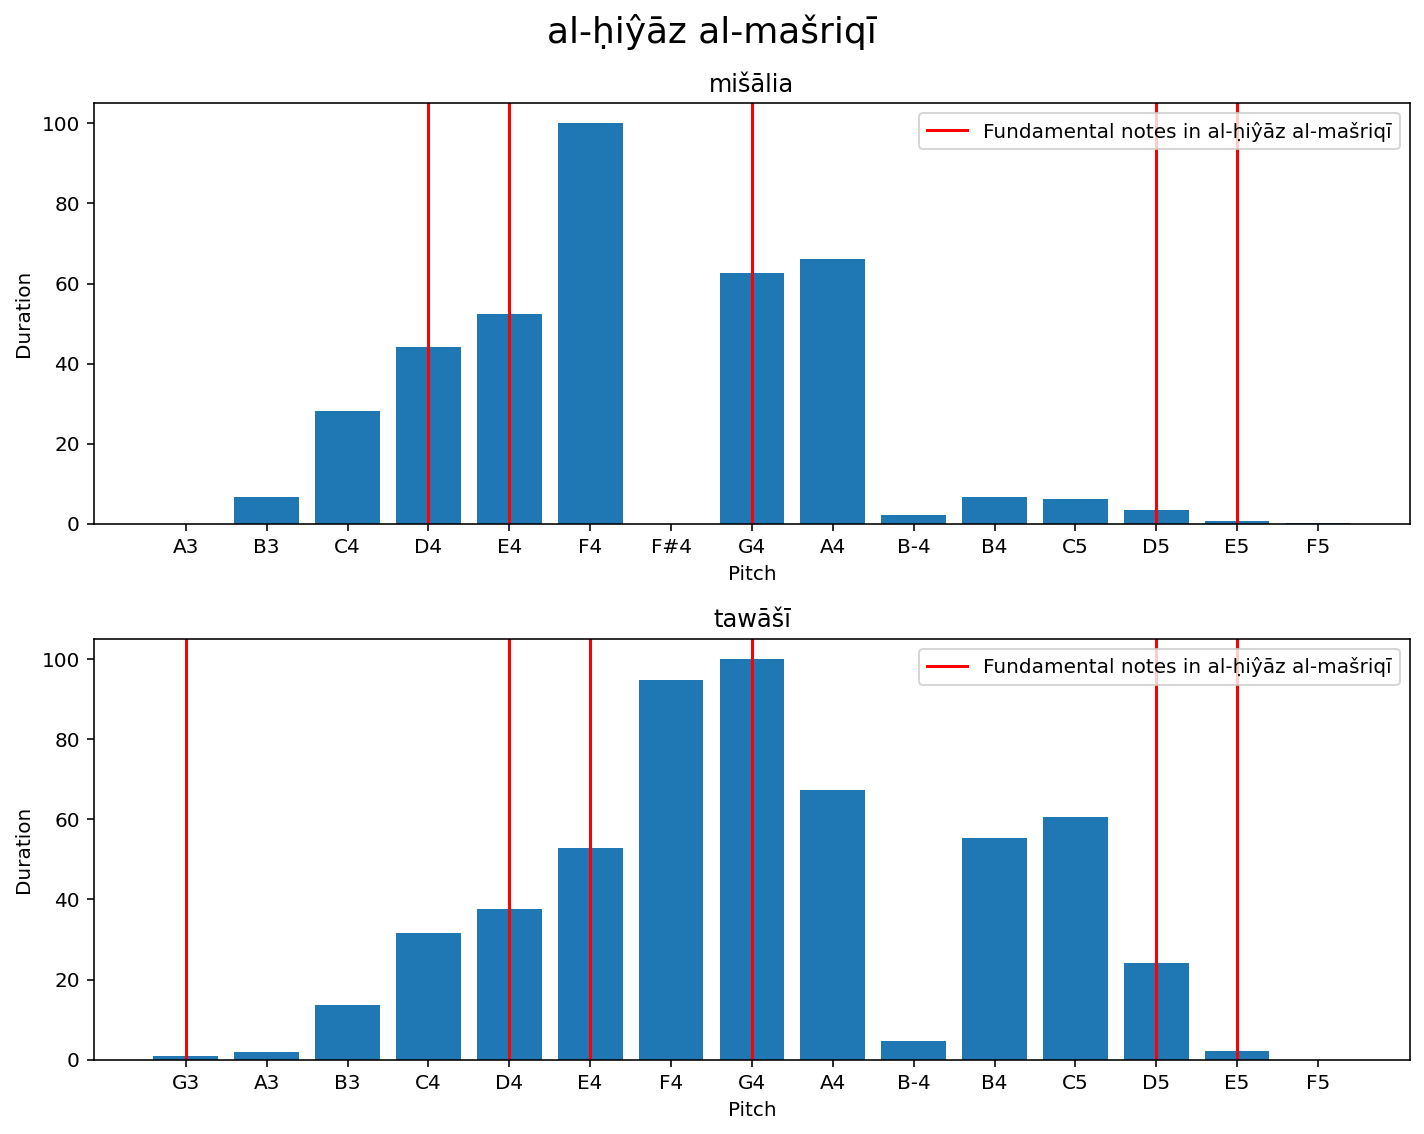

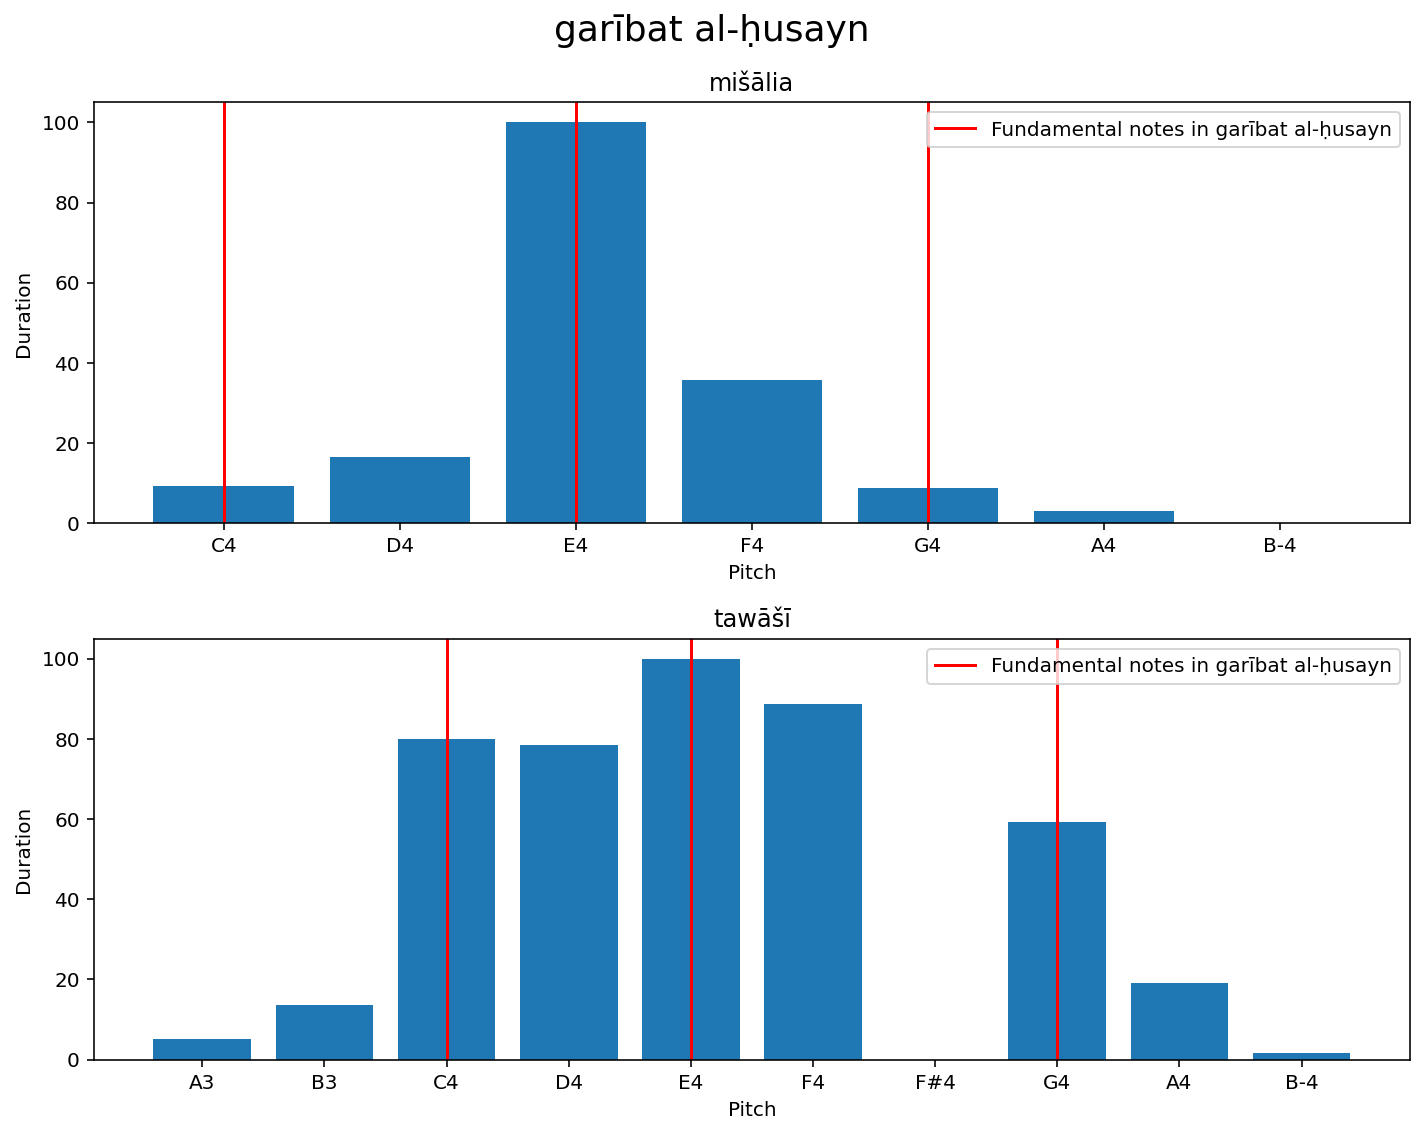

In [42]:
def normalize(d, target=100.0):
    '''
    Apply min-max normalization and put them between 0-100
    '''
    minimum = min(d)
    maximum = max(d)

    return[round((value-minimum)/(maximum - minimum)*target, 2) for value in d]

def sort_by_midi_note(pitch_histogram_dict):
    '''
    Given a dictionary of form {C4:100, B5:23, F#2: 1.25} sort by their midi value,
    Expected result: {F#2: 1.25, C4:100, B5:23}
    '''
    items = pitch_histogram_dict.items()
    midi_notes= [note.Note(n).pitch.midi for n in pitch_histogram_dict.keys()]
    midi_mapping = {note.Note(k).pitch.midi: k for k, value in items}
    #print('midi_note_mapping', midi_mapping)
    sorted_midi_notes = sorted(midi_notes)
    #print('sorted midi notes list', sorted_midi_notes)
    sorted_note_names = [midi_mapping[midi_note] for midi_note in sorted_midi_notes]
    #print('sorted real notes list', sorted_note_names)

    sorted_section = {}

    for key in sorted_note_names:
        sorted_section[key] = nawba_synthetised[nawba][section][key]
    #print(sorted_section)
    
    return sorted_section

def markers_by_nawba(nawba):
    modes = {
        '‘irāq al-‘aŷam':['G3', 'G4', 'G5', 'B3', 'B4', 'D3', 'D4'],
        'al-raṣd': ['D3', 'D4', 'D5','G3', 'G4', 'G5',  'F3', 'F4'],
        'al-istihlāl': ['C3', 'C4','E3', 'E4','G3', 'G4'],
        'raṣd al-ḏāyl': ['C3','C4', 'D3', 'D4' ,'E3', 'E4','G3', 'G4'],
        'al-iṣbahān': ['G3', 'G4', 'G5', 'B3', 'B4', 'D3', 'D4', 'E3', 'E4'],
        'al-‘uššāq': ['G3', 'G4', 'G5','D3', 'D4', 'D5'],
        'al-ḥiŷāz al-kabīr': ['D3', 'D4', 'D5','G3', 'G4', 'G5',  'A3', 'A4'],
        'al-māya': ['C3', 'C4', 'C5', 'E3', 'E4','G3', 'G4'],
        'raml al-māya': [ 'D3', 'D4', 'D5', 'F3', 'F4', 'G3', 'G4', 'G5',  'A3', 'A4'],
        'al-ḥiŷāz al-mašriqī': ['D3', 'D4', 'D5', 'E3', 'E4', 'E5', 'G3', 'G4', 'G5'],
        'garībat al-ḥusayn': ['G3', 'G4', 'G5', 'C3', 'C4', 'E3', 'E4']
        
    }
    if nawba in modes:
        return modes[nawba]
    else:
        return []
    
for nawba in nawba_synthetised:
    print('--------')
    print('Plotting..%s' %(nawba))
    
    fig, axs = plt.subplots( 2, figsize=(10, 8))

    fig.suptitle('%s'% (nawba), fontsize=18)
   
    y = 0
    for section in nawba_synthetised[nawba].keys():       
        #print('original', nawba_synthetised[nawba][section])
        ## Order by MIDI
        sorted_section = sort_by_midi_note(nawba_synthetised[nawba][section])
        
        x_0 = sorted_section.keys()
        y_0 = normalize(sorted_section.values())

        axs[y].title.set_text(section)
        axs[y].bar(x_0, y_0)
        axs[y].set_xlabel('Pitch')
        axs[y].set_ylabel('Duration')
        for mark in markers_by_nawba(nawba):
            if mark not in x_0:
                continue
            axs[y].axvline(x=mark, c='red')
        axs[y].legend(['Fundamental notes in %s'%(nawba)])
        plt.savefig('misalia_tawasi_pitch_characterization_%s.png'%(nawba), transparent=True)
        y+=1
    fig.tight_layout()
    plt.plot()
    
    

## Centos agroupation By Nawba

In [39]:
def read_centos_counter_file():
    with open('misalia_tawasi_centos_counter_by_mbid.json', 'r') as outfile:
        centos_counter = json.load(outfile)
    return centos_counter
 
#if not histogram:
centos_counter = read_centos_counter_file()

    
with open('mbid_nawba.json', 'r') as mapping:
    nawbas_mapping = json.load(mapping)
    
sectionNames = ['mišālia','tawāšī']

In [40]:
centos_grouped_by_nawbas = {}

for mbid in centos_counter:
    #print(centos_counter[mbid])
    nawba_type = nawbas_mapping[mbid]
    
    if not nawba_type in centos_grouped_by_nawbas:
        centos_grouped_by_nawbas[nawba_type] = {}
        #{'al maya': {'hhjf-dfdf-df': {misalia:{}, tawasi:{}}}
        
    if not mbid in centos_grouped_by_nawbas[nawbas_mapping[mbid]]:
        centos_grouped_by_nawbas[nawba_type][mbid] = {}
        
    if sectionNames[0] in centos_counter[mbid]:
        if not sectionNames[0] in centos_grouped_by_nawbas[nawba_type][mbid]:
            centos_grouped_by_nawbas[nawba_type][mbid][sectionNames[0]] = {}
     
        centos_grouped_by_nawbas[nawba_type][mbid].update(
            {
                sectionNames[0]: centos_counter[mbid][sectionNames[0]]
            }
        )
    if sectionNames[1] in centos_counter[mbid]:
        if not sectionNames[1] in centos_grouped_by_nawbas[nawba_type][mbid]:
            centos_grouped_by_nawbas[nawba_type][mbid][sectionNames[1]] = {}
            
        centos_grouped_by_nawbas[nawba_type][mbid].update(
            {
                sectionNames[1]: centos_counter[mbid][sectionNames[1]]
            }
        )

In [41]:
pprint.pprint(centos_grouped_by_nawbas)

{'al-istihlāl': {'023b4a37-1ab4-4593-b03a-850ee0db8350': {'mišālia': {'C2': 4,
                                                                      'C4': 6,
                                                                      'C6': 5},
                                                          'tawāšī': {'C1': 2,
                                                                     'C2': 18,
                                                                     'C4': 12,
                                                                     'C6': 16}},
                 '1630e9c2-3c01-4959-a633-7dbacbc7616e': {'mišālia': {'C2': 2,
                                                                      'C4': 3,
                                                                      'C6': 3}},
                 '33423585-e406-40ec-ba28-88b0768cb668': {'mišālia': {'C2': 5,
                                                                      'C4': 9,
                                                

In [44]:
def read_intervals_file():
    with open('misalia_tawasi_intervals_by_mbid.json', 'r') as outfile:
        intervals = json.load(outfile)
    return intervals
 
#if not histogram:
intervals = read_intervals_file()

    
with open('mbid_nawba.json', 'r') as mapping:
    nawbas_mapping = json.load(mapping)
    
sectionNames = ['mišālia','tawāšī']

In [45]:
intervals_grouped_by_nawba = {}

for mbid in intervals:
    #print(intervals[mbid])
    nawba_type = nawbas_mapping[mbid]
    
    if not nawba_type in intervals_grouped_by_nawba:
        intervals_grouped_by_nawba[nawba_type] = {}
        #{'al maya': {'hhjf-dfdf-df': {misalia:{}, tawasi:{}}}
        
    if not mbid in intervals_grouped_by_nawba[nawbas_mapping[mbid]]:
        intervals_grouped_by_nawba[nawba_type][mbid] = {}
        
    if sectionNames[0] in intervals[mbid]:
        if not sectionNames[0] in intervals_grouped_by_nawba[nawba_type][mbid]:
            intervals_grouped_by_nawba[nawba_type][mbid][sectionNames[0]] = {}
     
        intervals_grouped_by_nawba[nawba_type][mbid].update(
            {
                sectionNames[0]: intervals[mbid][sectionNames[0]]
            }
        )
    if sectionNames[1] in intervals[mbid]:
        if not sectionNames[1] in intervals_grouped_by_nawba[nawba_type][mbid]:
            intervals_grouped_by_nawba[nawba_type][mbid][sectionNames[1]] = {}
        intervals_grouped_by_nawba[nawba_type][mbid].update(
            {
                sectionNames[1]: intervals[mbid][sectionNames[1]]
            }
        )
pprint.pprint(intervals_grouped_by_nawba)

{'al-istihlāl': {'023b4a37-1ab4-4593-b03a-850ee0db8350': {'mišālia': {'M2': 63,
                                                                      'P1': 48,
                                                                      'm2': 52},
                                                          'tawāšī': {'M2': 144,
                                                                     'M3': 10,
                                                                     'P1': 55,
                                                                     'm2': 72,
                                                                     'm3': 2}},
                 '1630e9c2-3c01-4959-a633-7dbacbc7616e': {'mišālia': {'M2': 34,
                                                                      'P1': 24,
                                                                      'm2': 27}},
                 '33423585-e406-40ec-ba28-88b0768cb668': {'mišālia': {'M2': 24,
                                        

                                                                      'P1': 7,
                                                                      'P4': 4,
                                                                      'm2': 12,
                                                                      'm3': 4}},
                  '2cf367de-583b-4bd6-83f3-fc036fe19fab': {'mišālia': {'M2': 2348,
                                                                       'M3': 167,
                                                                       'P1': 610,
                                                                       'P4': 122,
                                                                       'P5': 8,
                                                                       'P8': 4,
                                                                       'm2': 969,
                                                                       'm3': 205}},
                  '2d91d7e

Plotting..‘irāq al-‘aŷam
Plotting..al-istihlāl
Plotting..al-raṣd
Plotting..raṣd al-ḏāyl
Plotting..al-iṣbahān
Plotting..al-‘uššāq
Plotting..al-ḥiŷāz al-kabīr
Plotting..al-māya
Plotting..raml al-māya
Plotting..al-ḥiŷāz al-mašriqī
Plotting..garībat al-ḥusayn


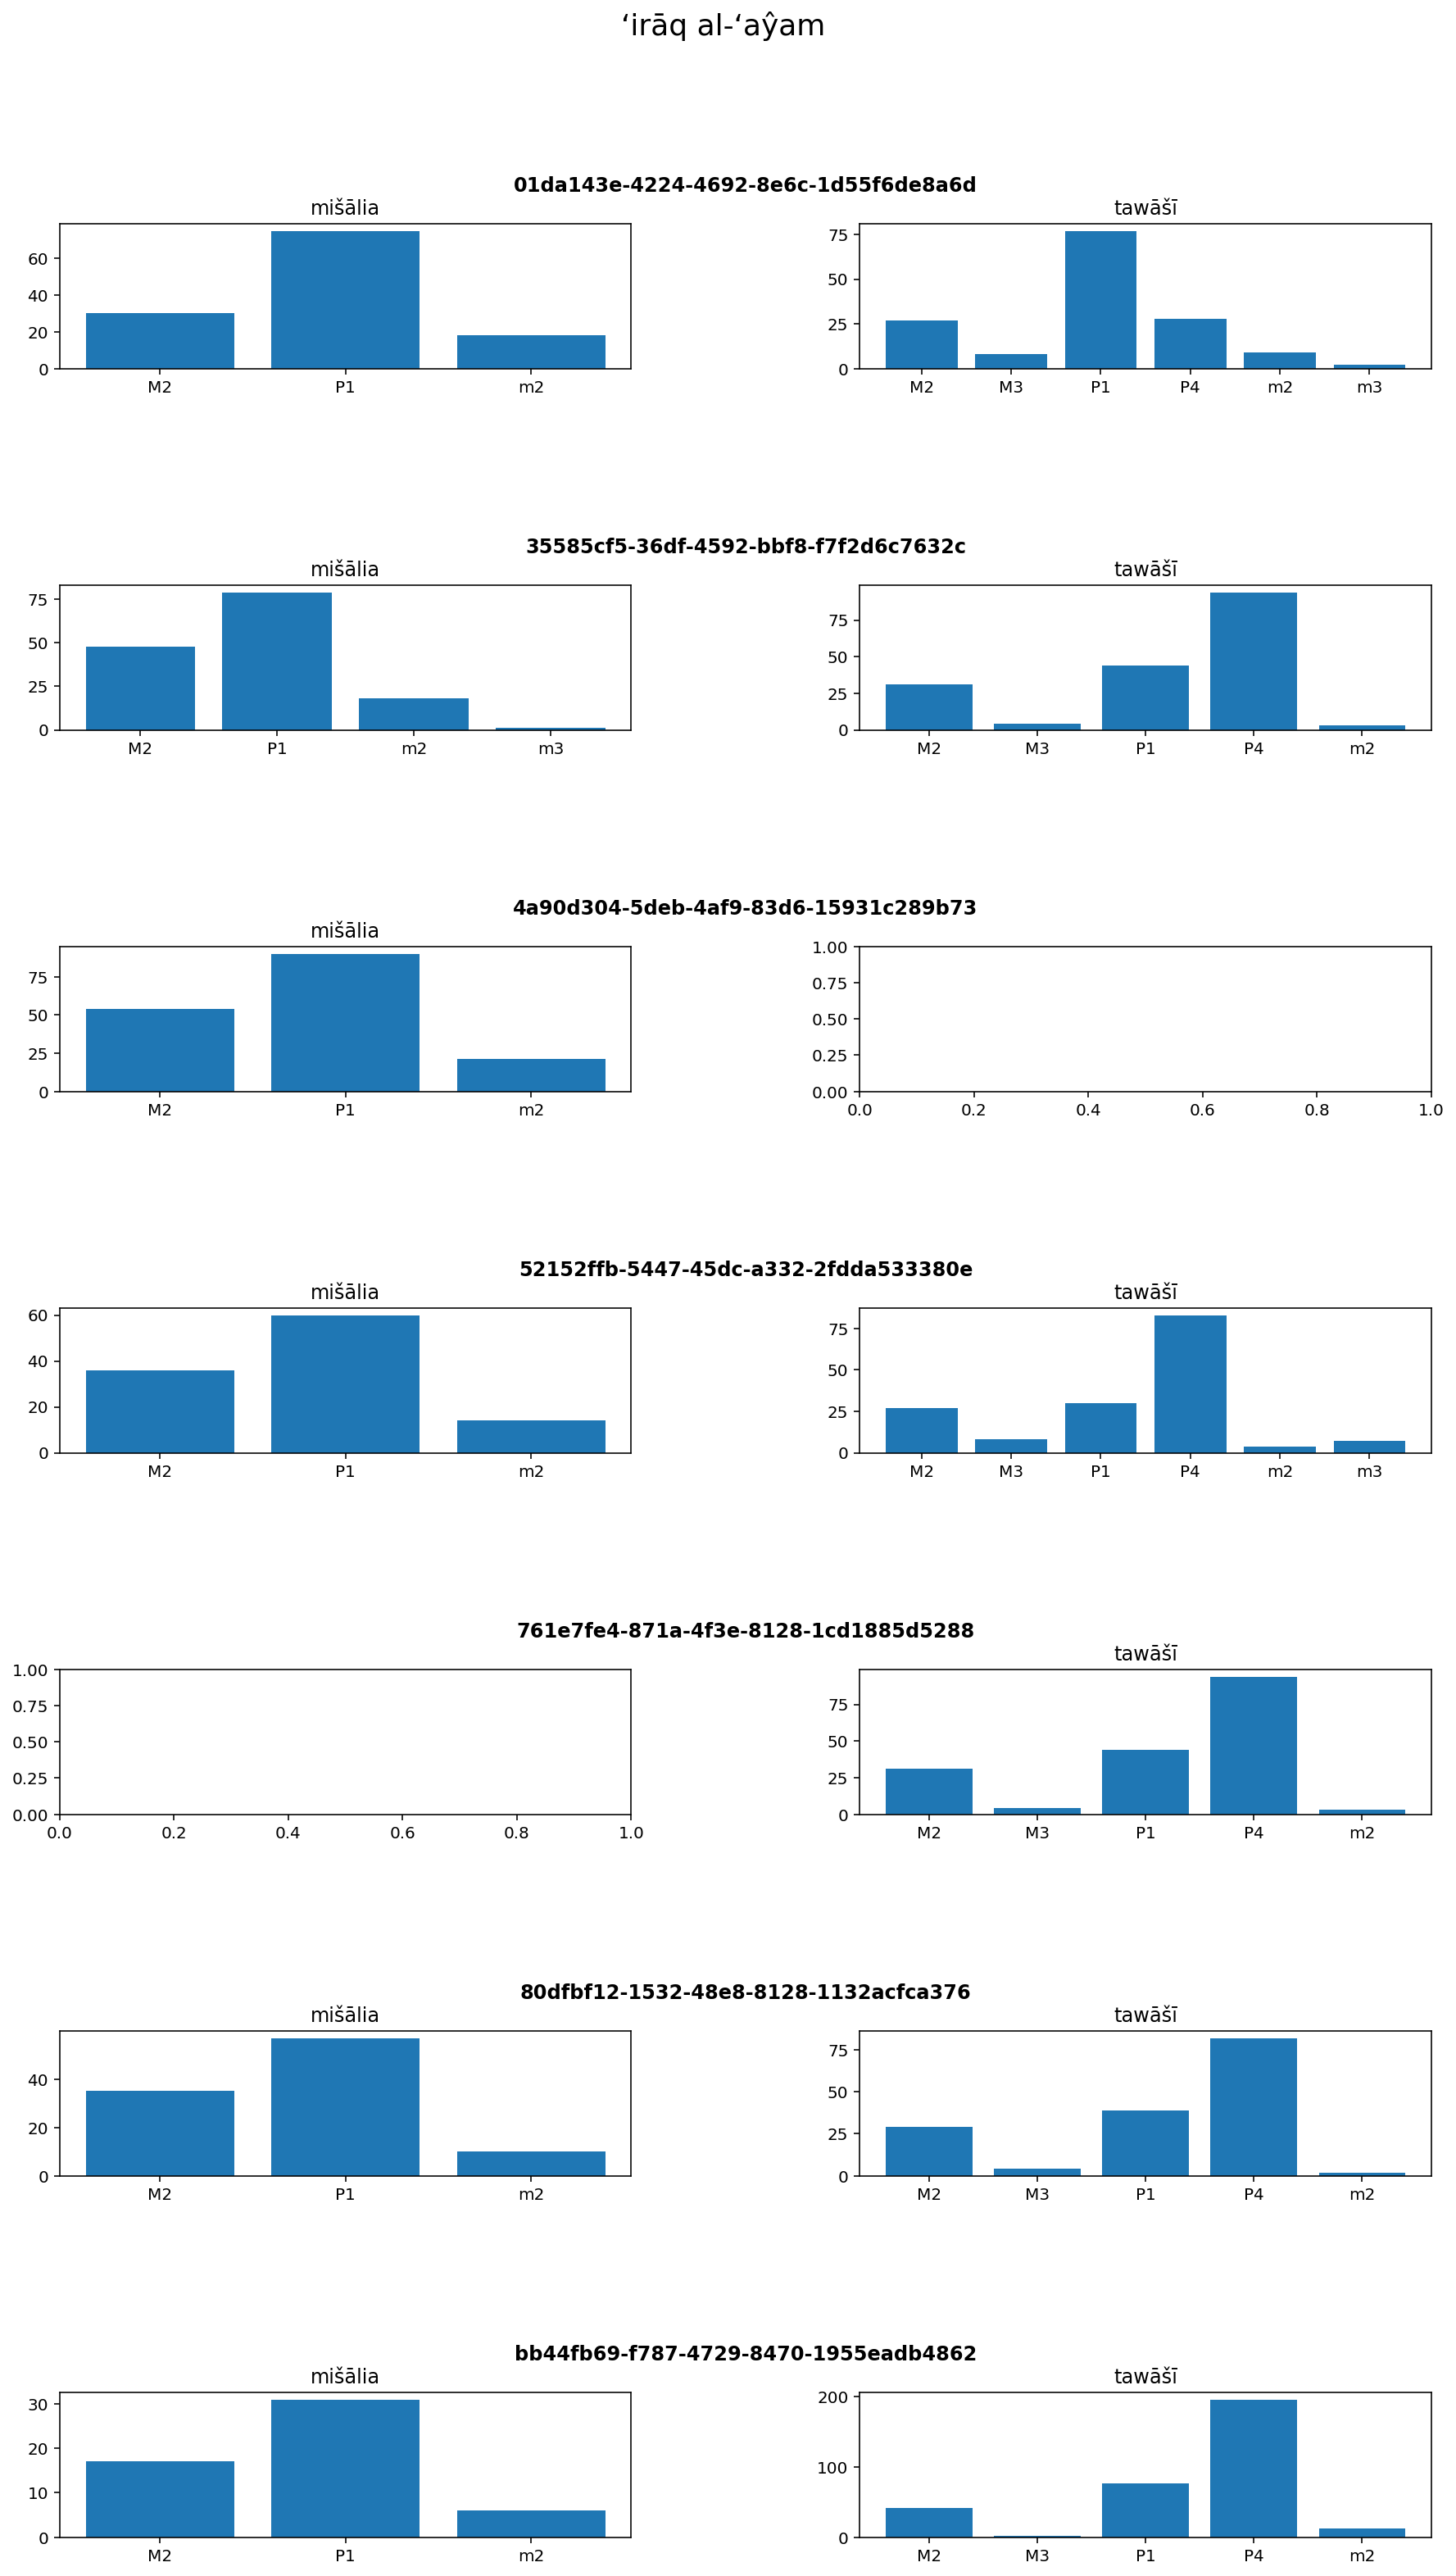

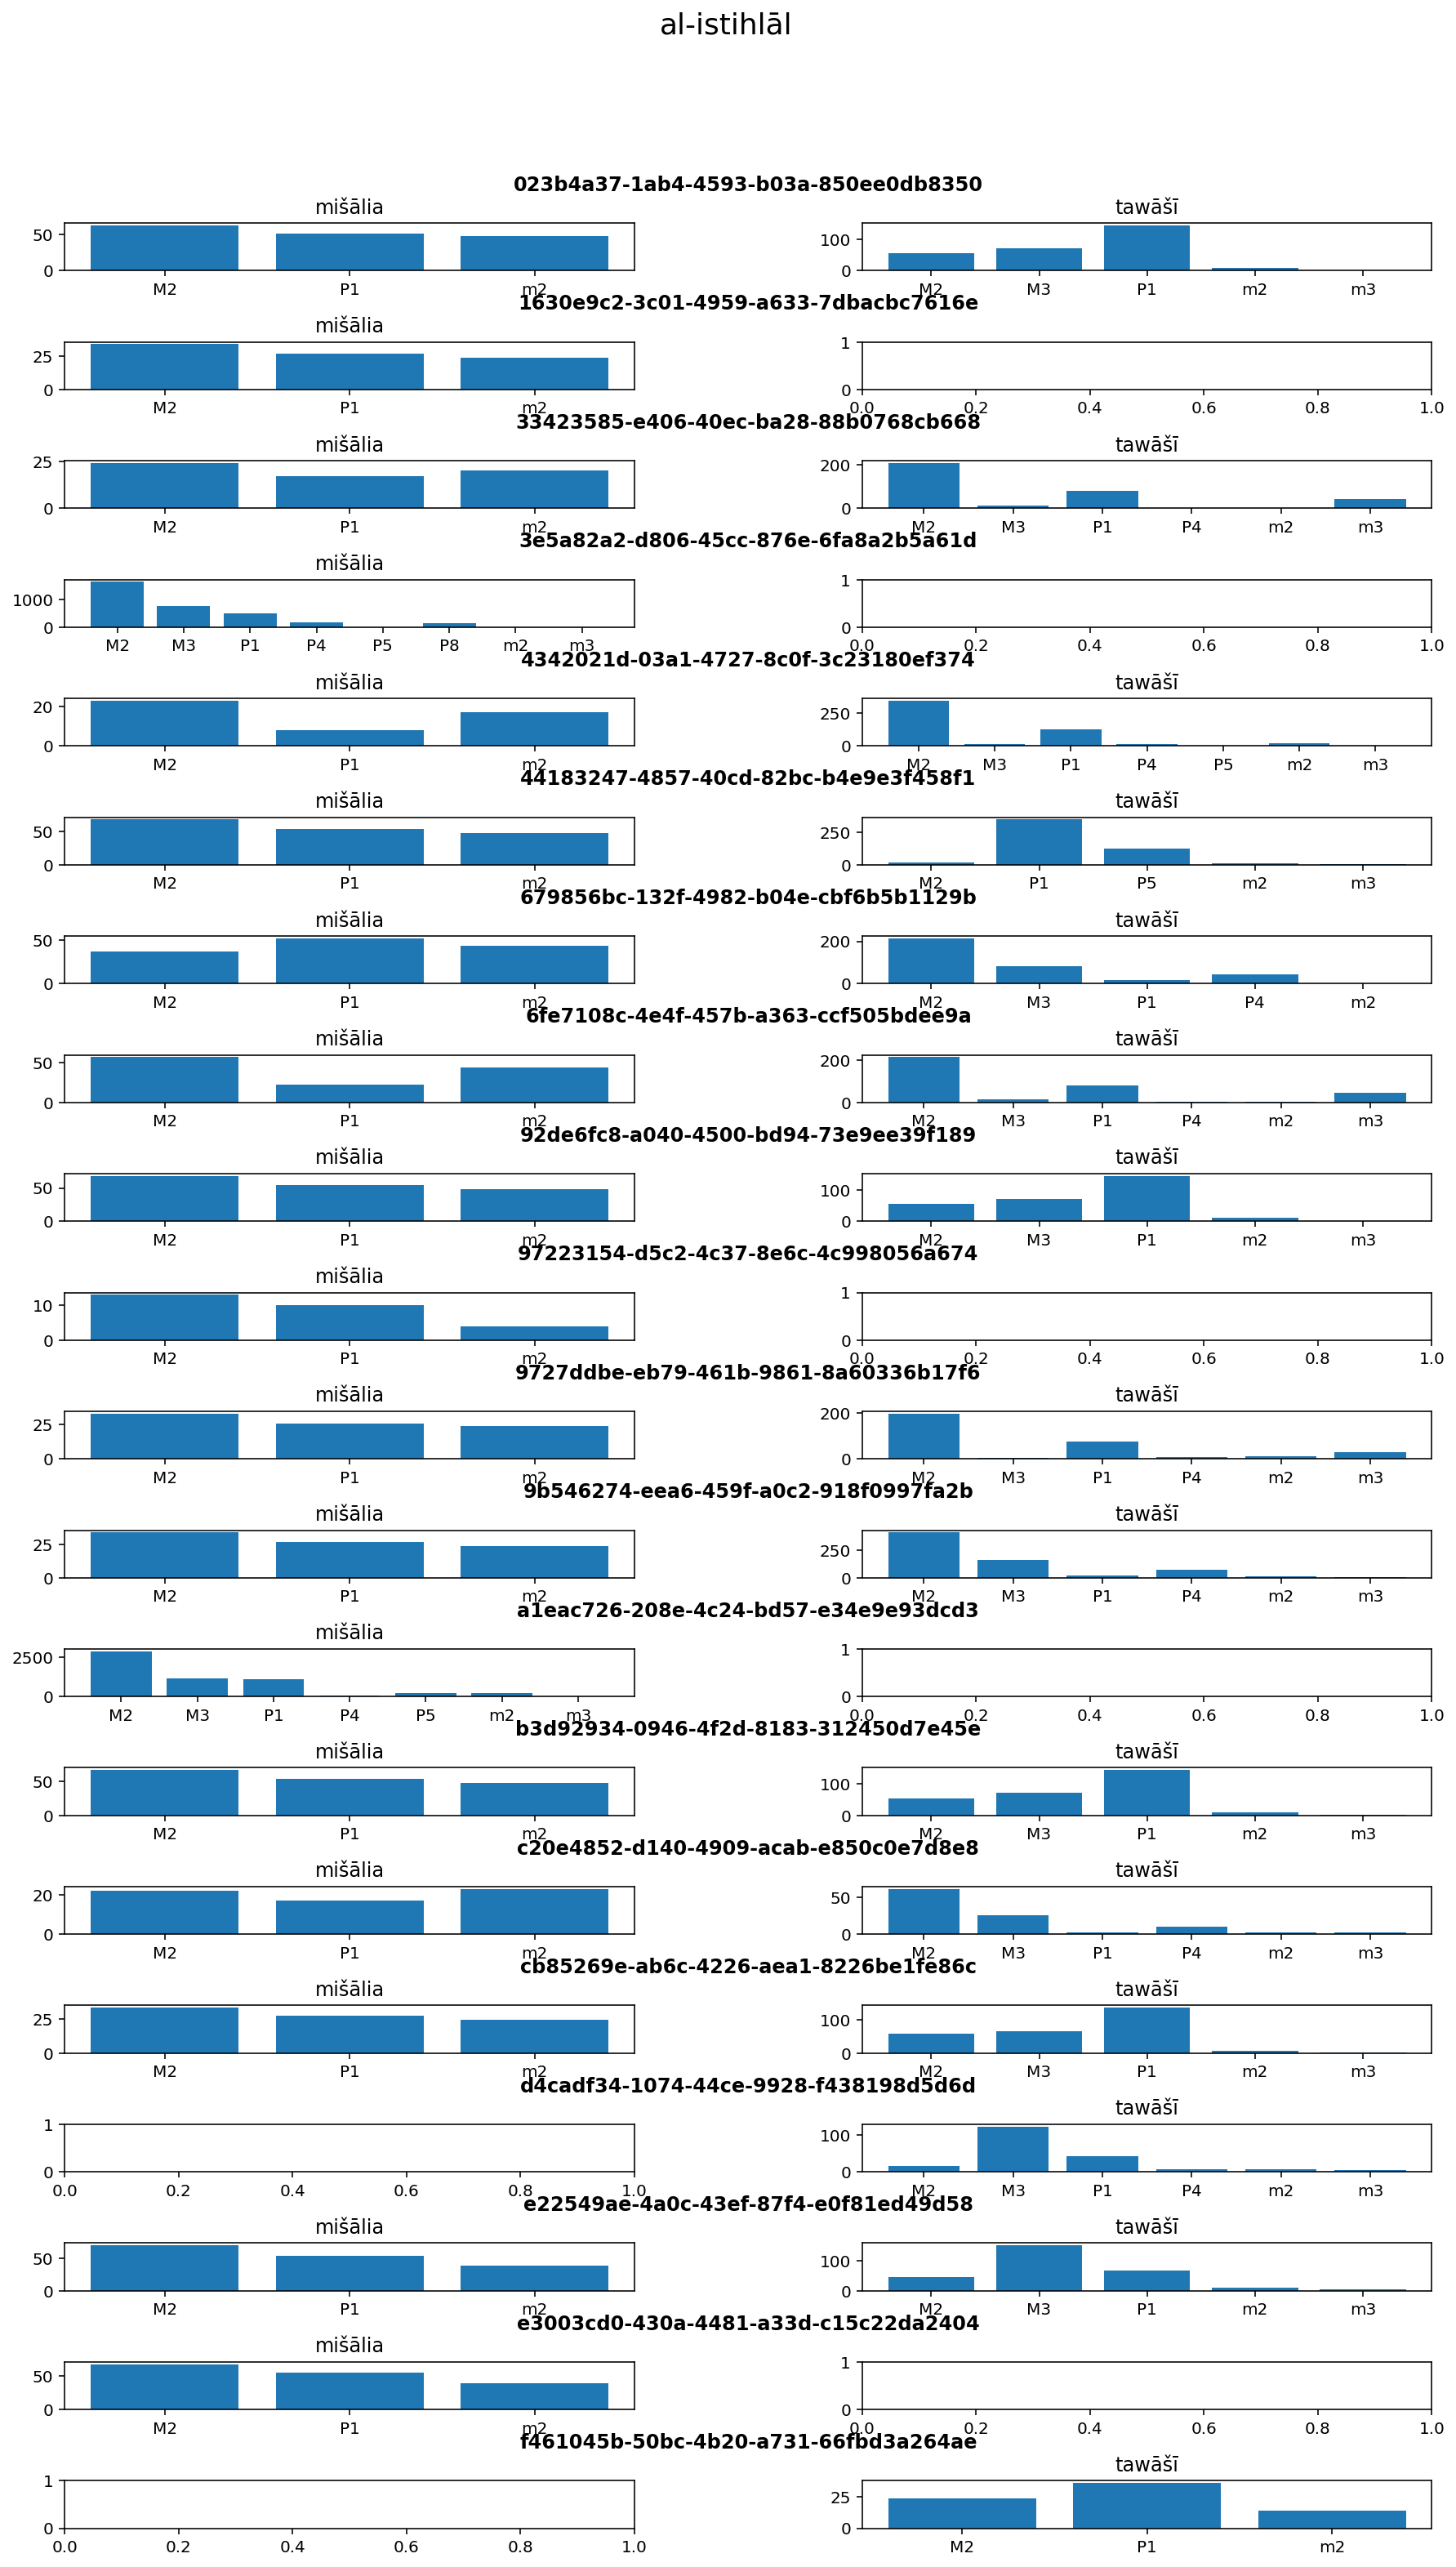

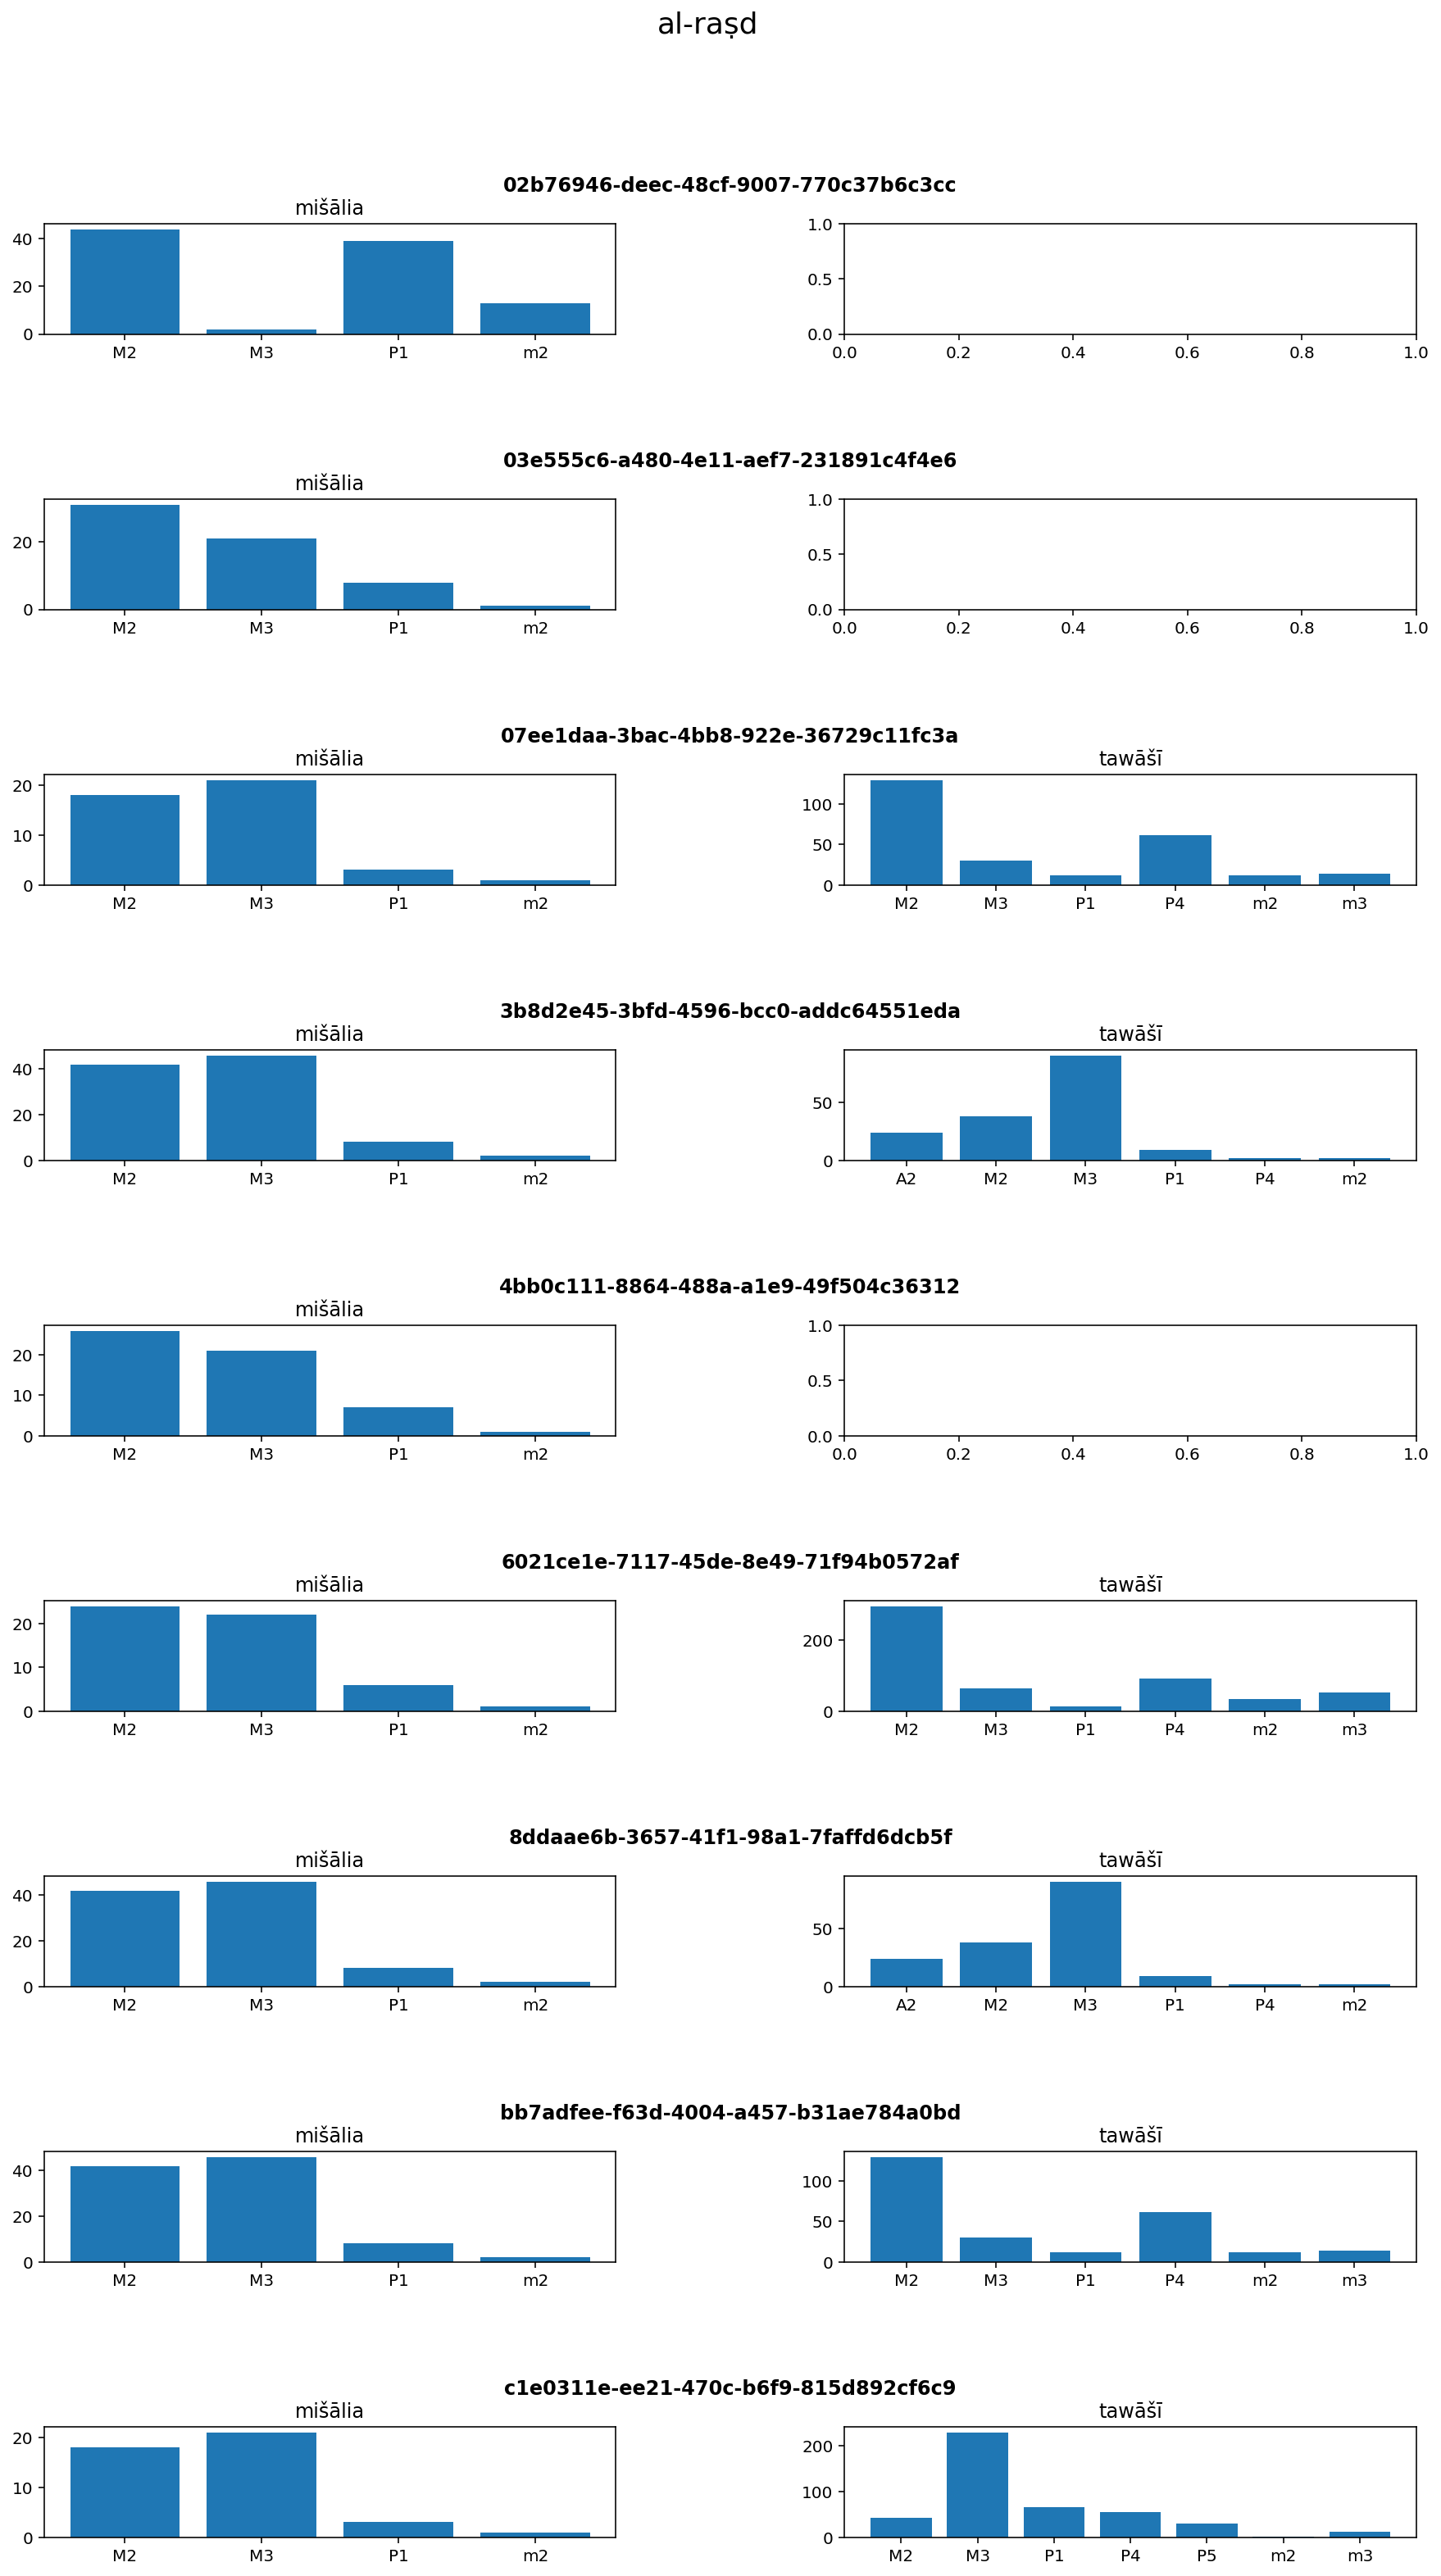

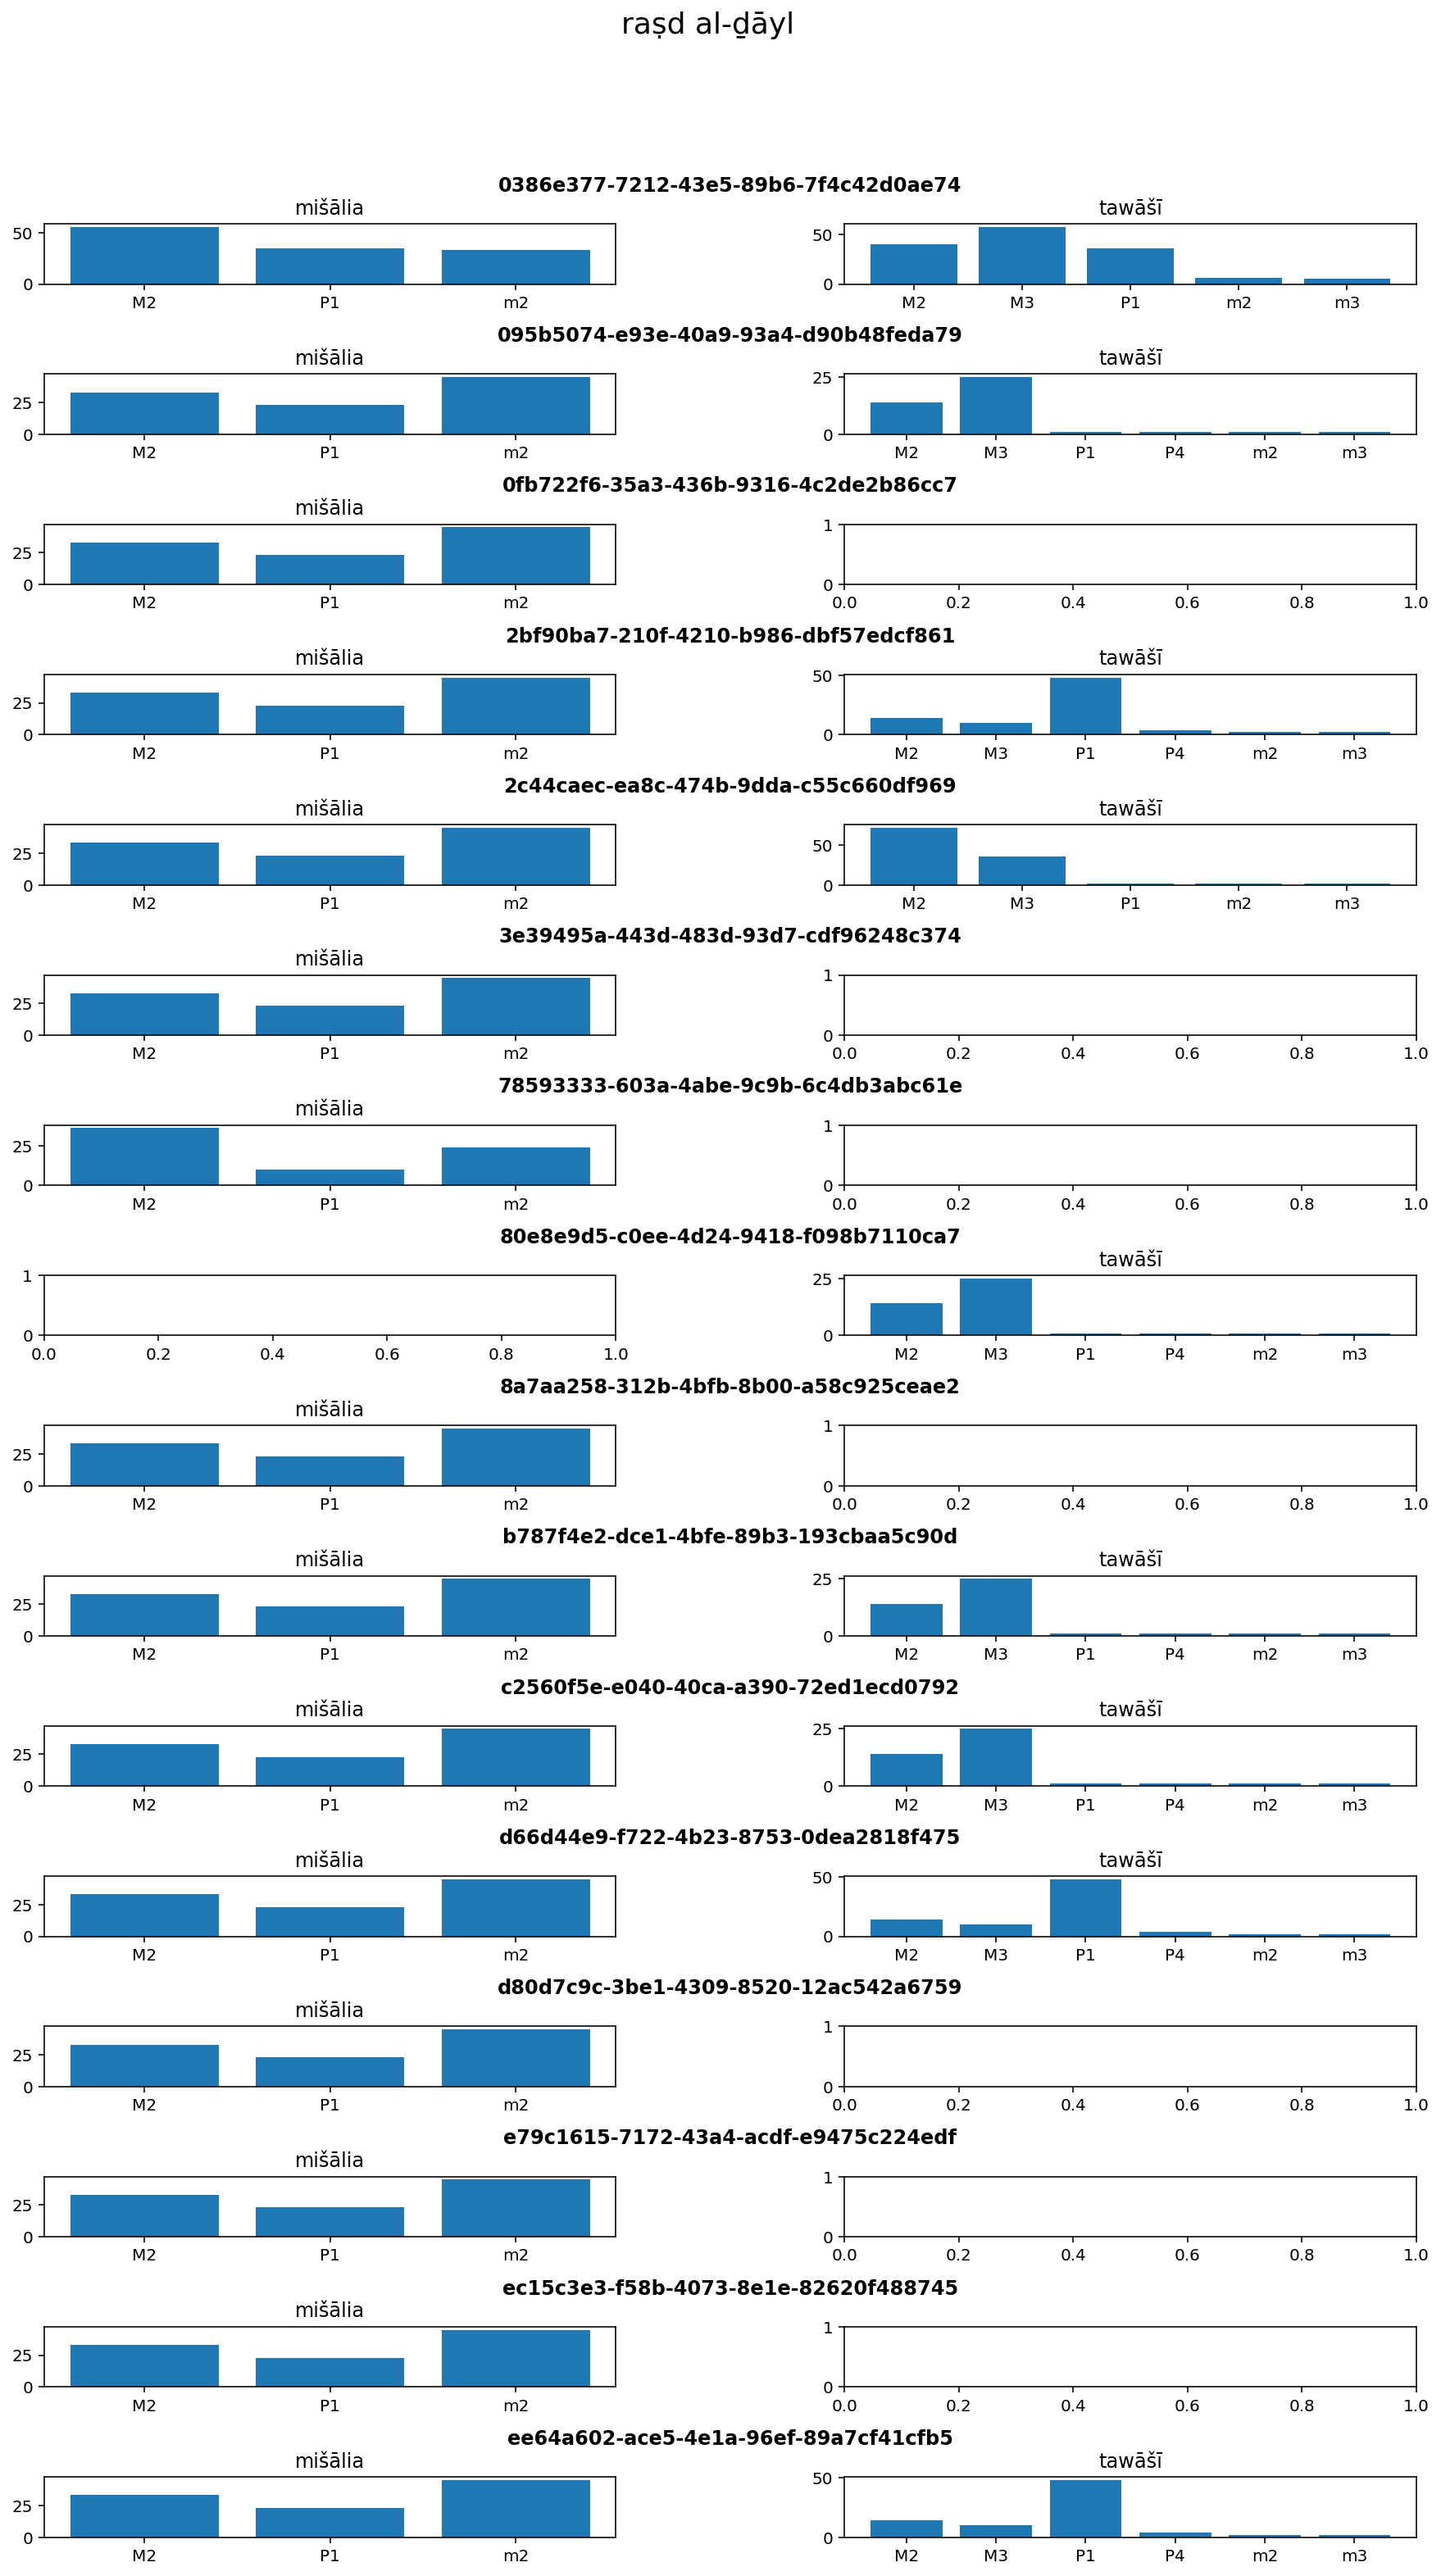

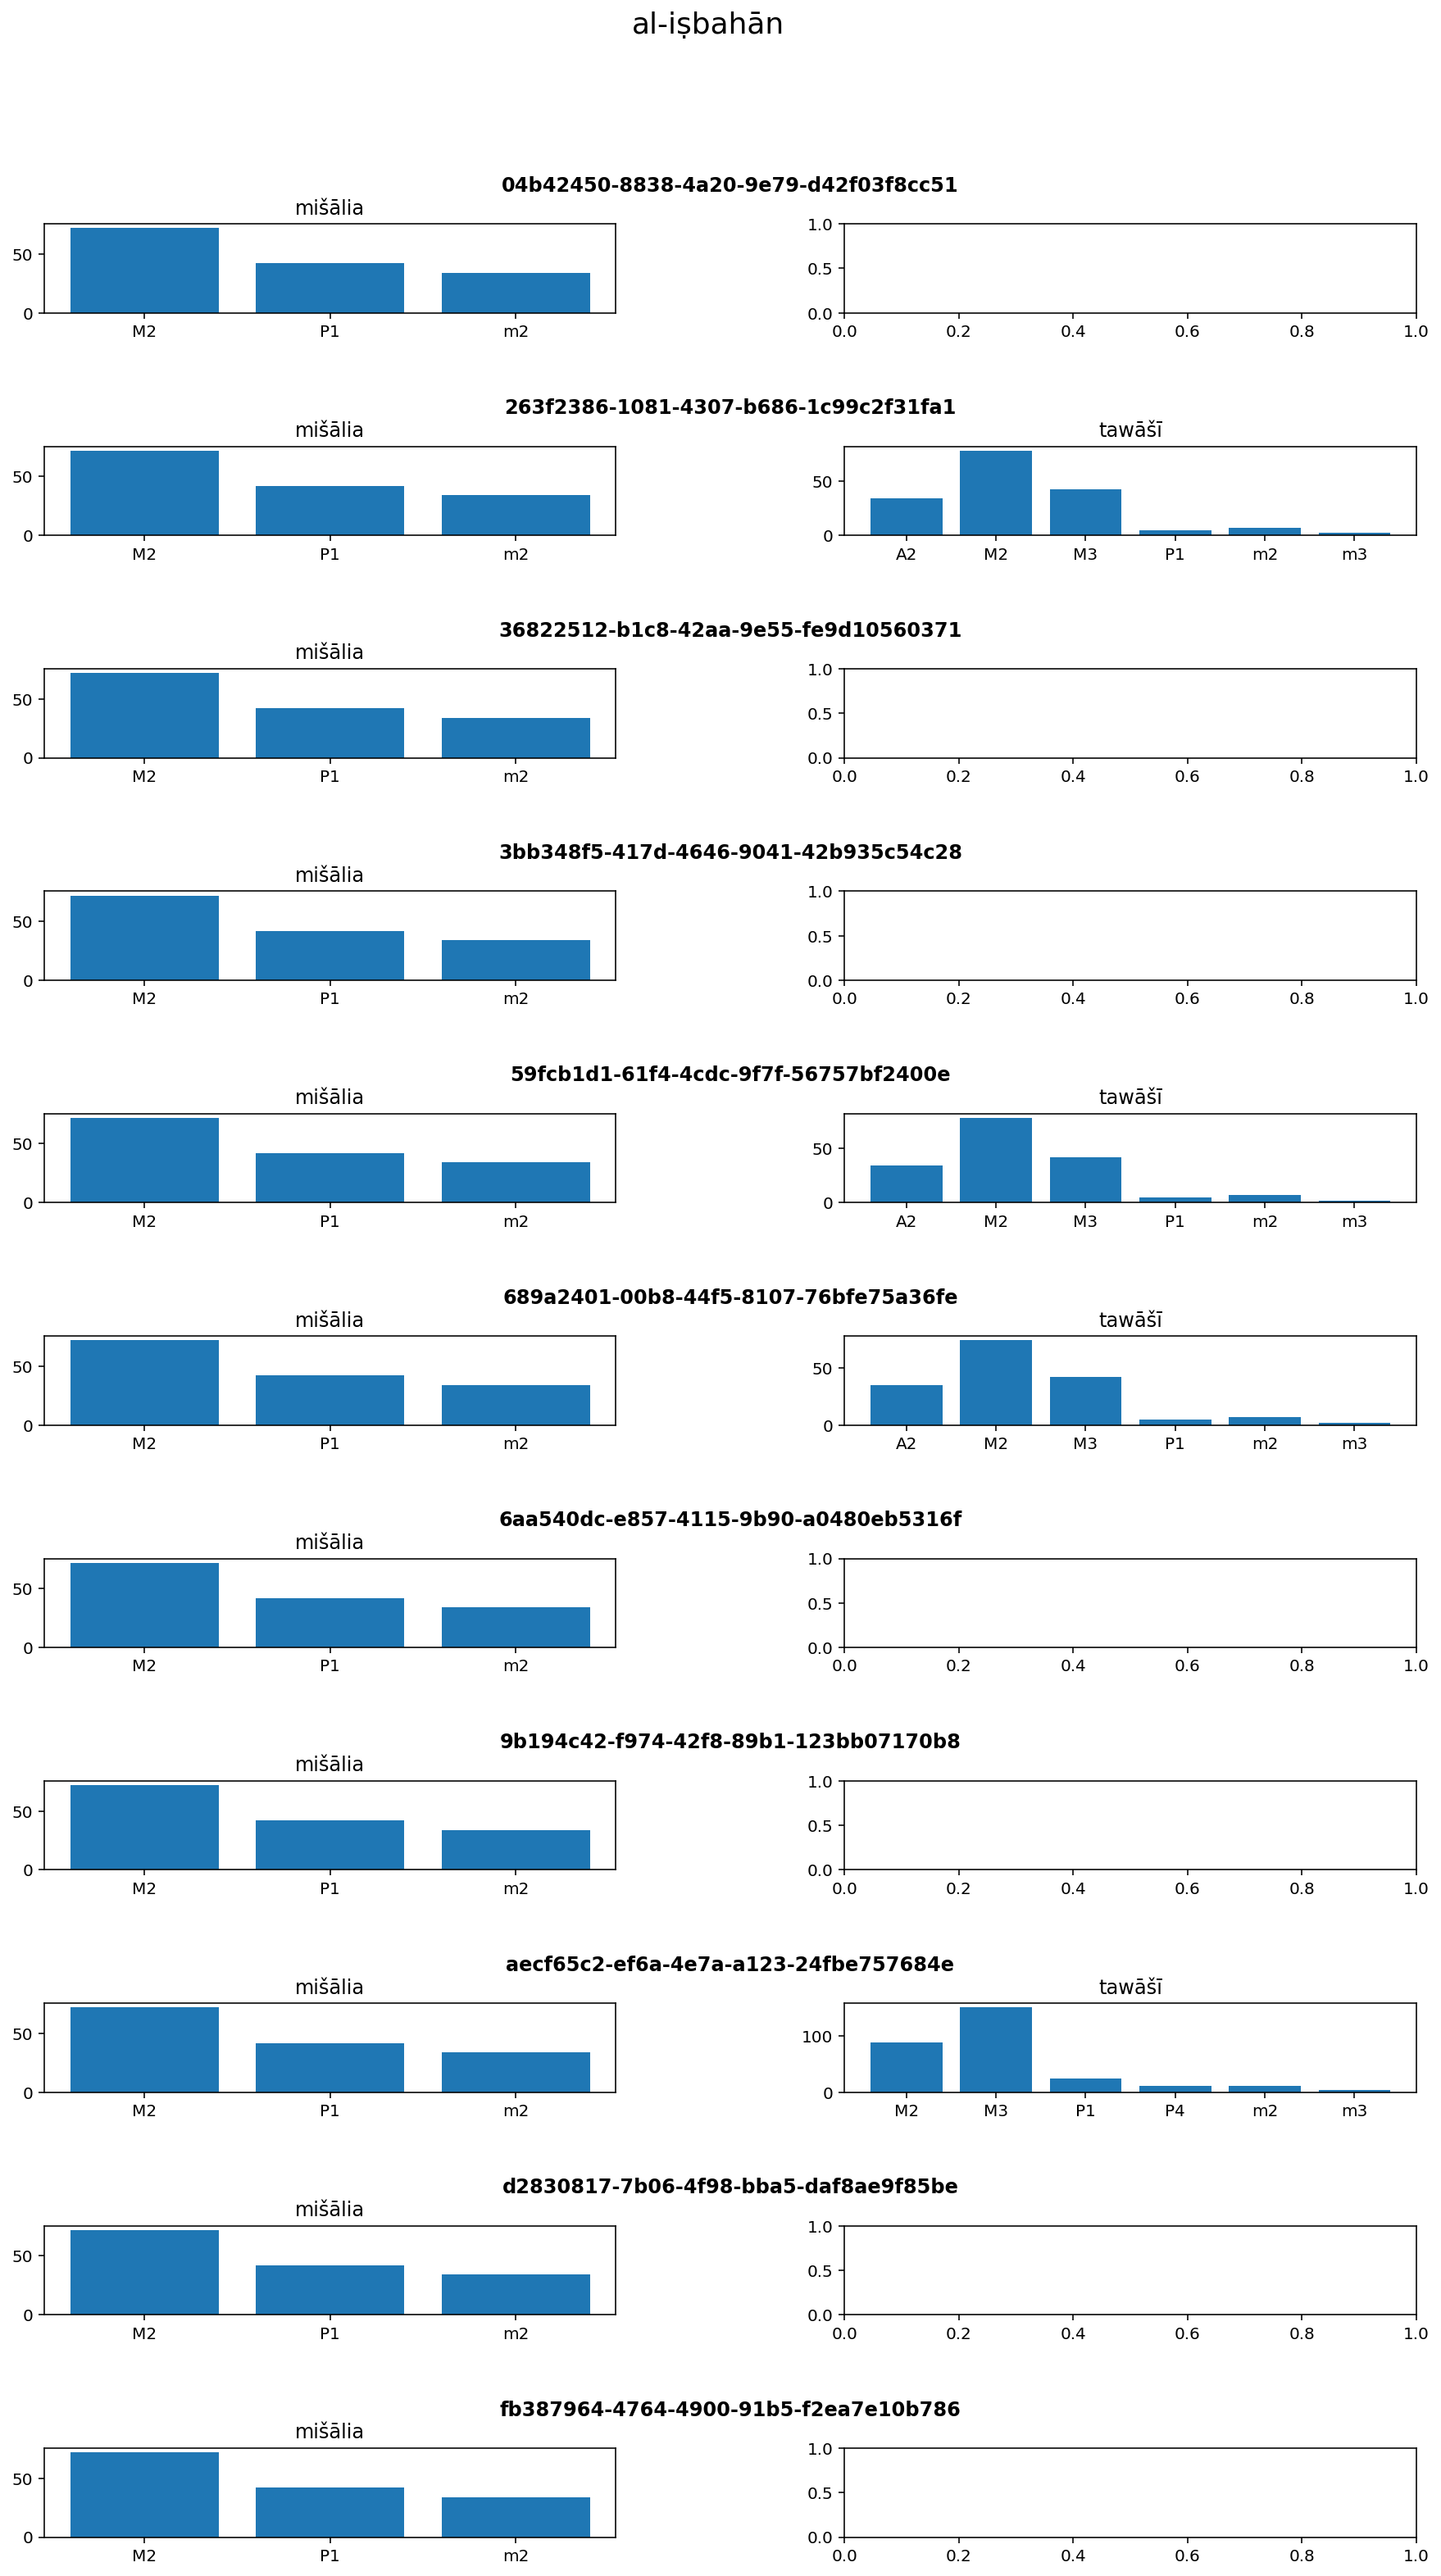

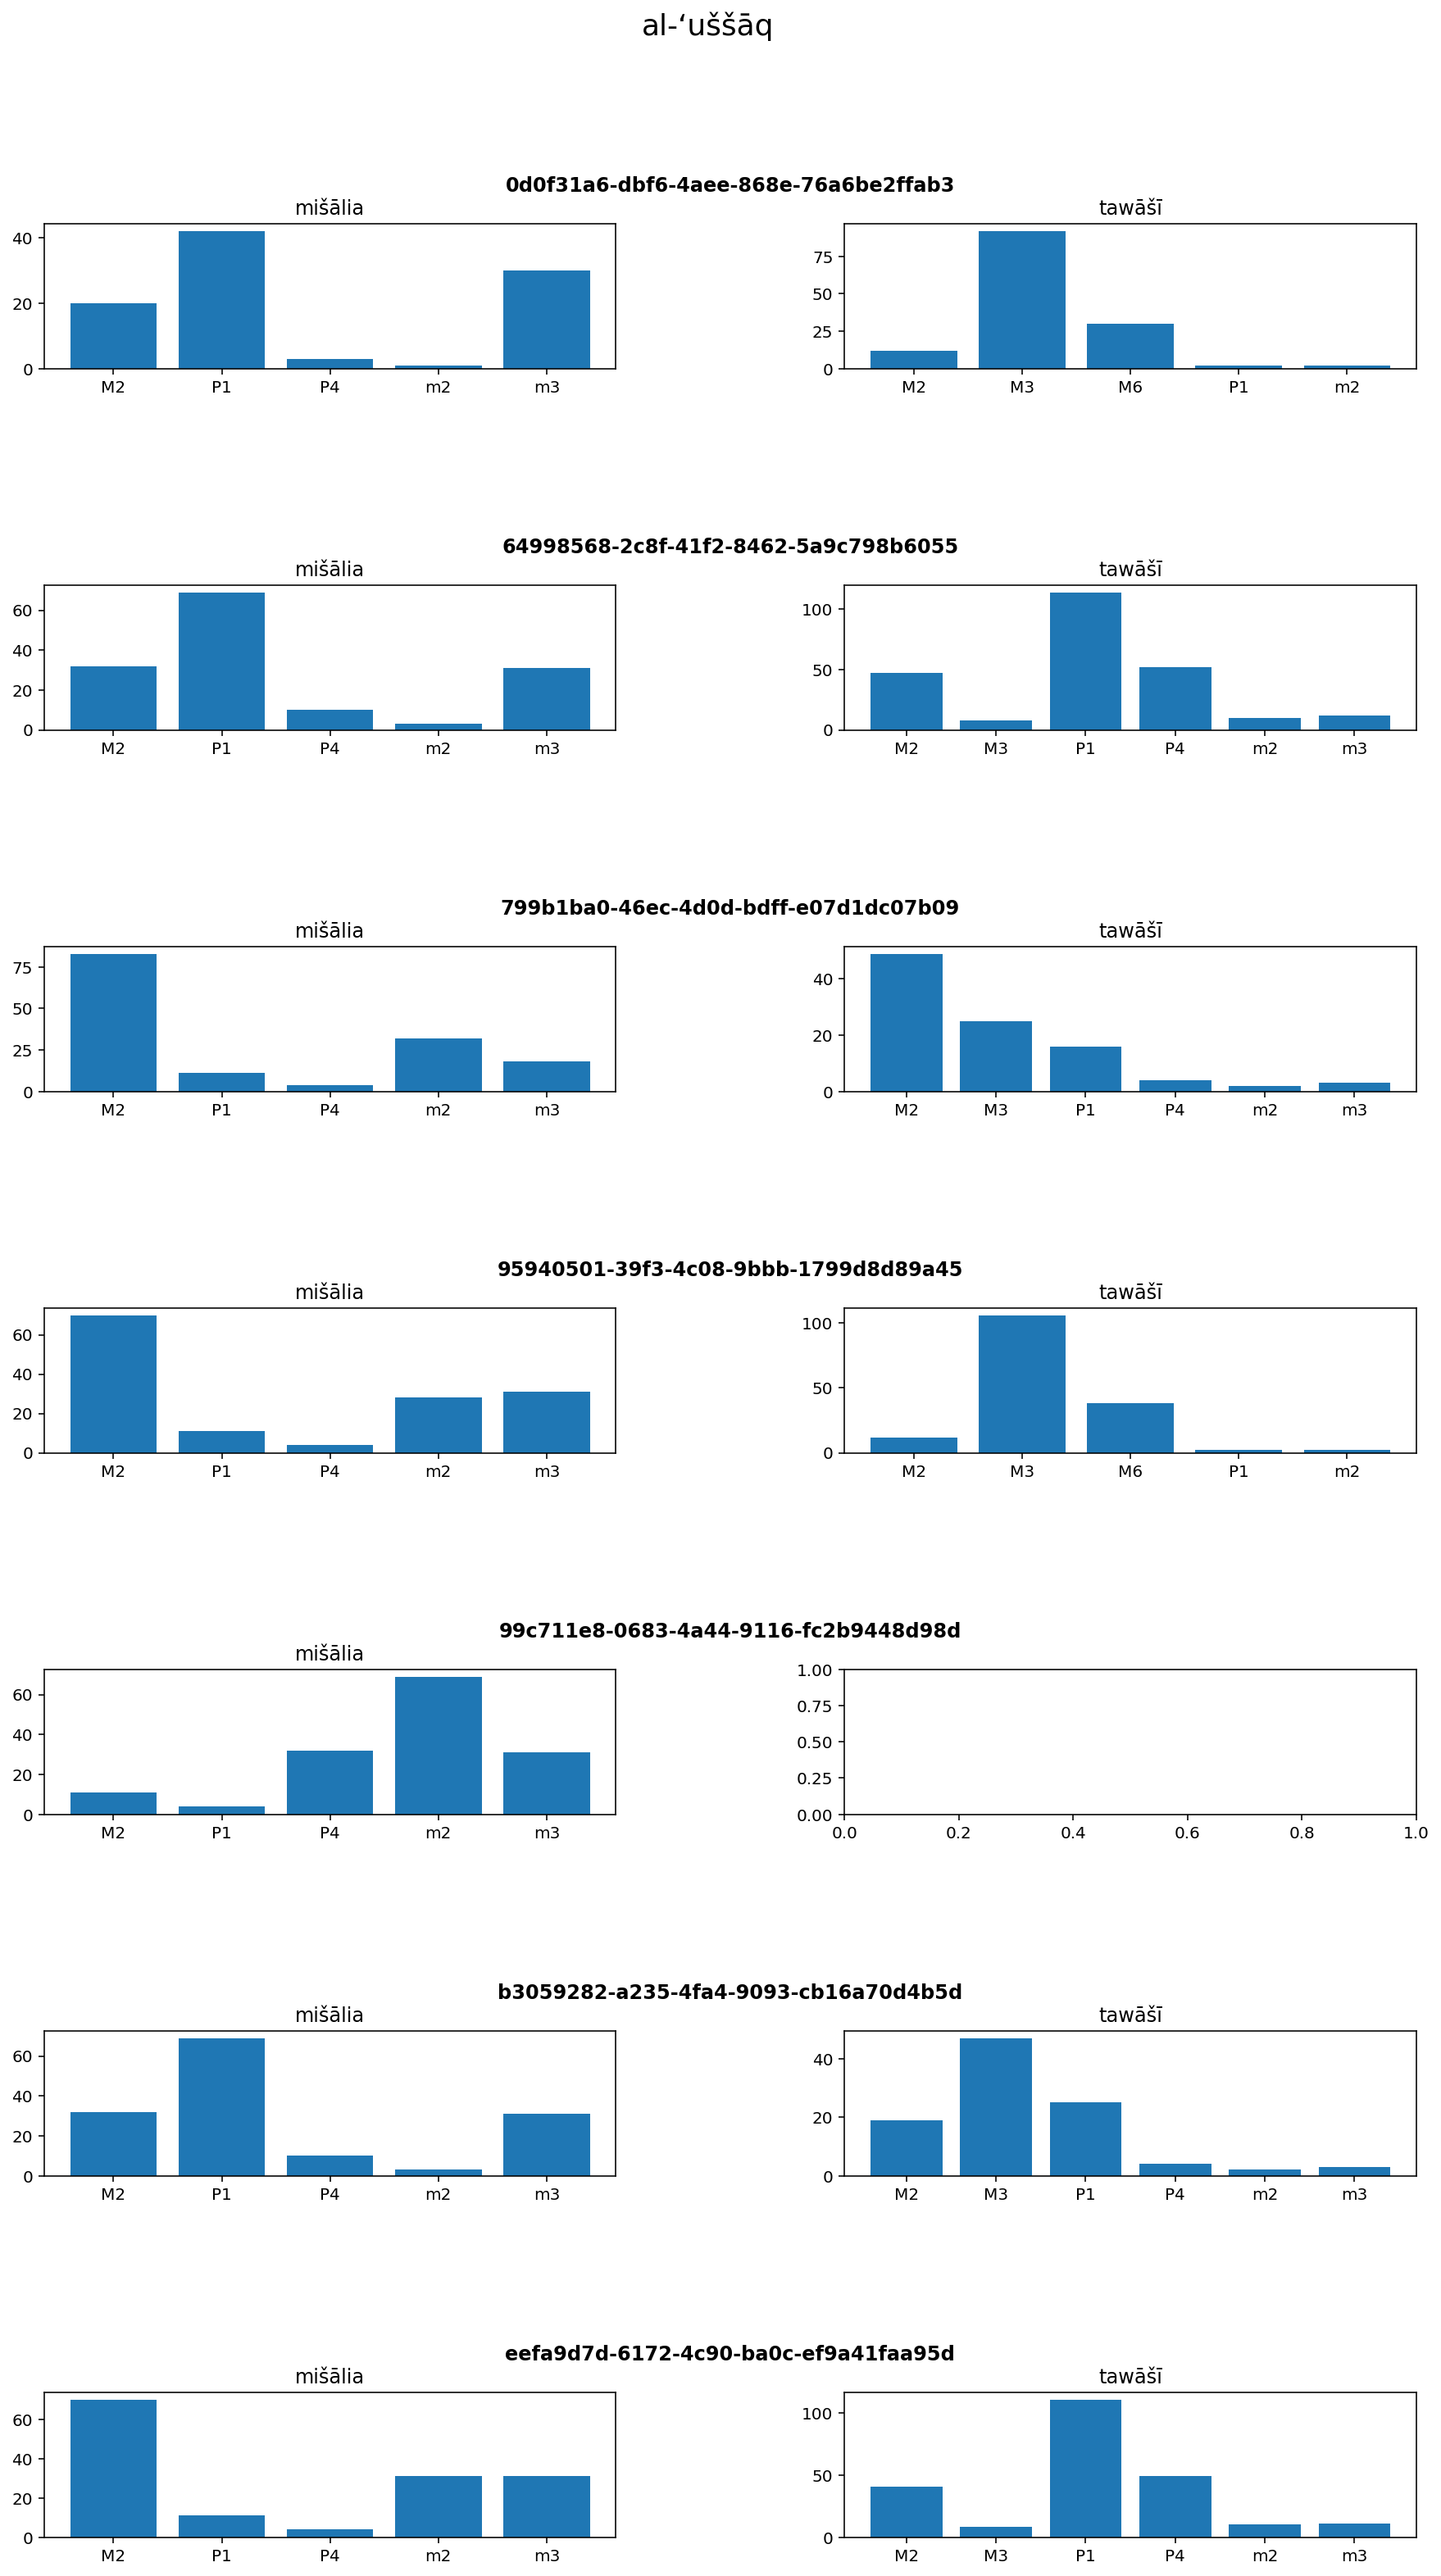

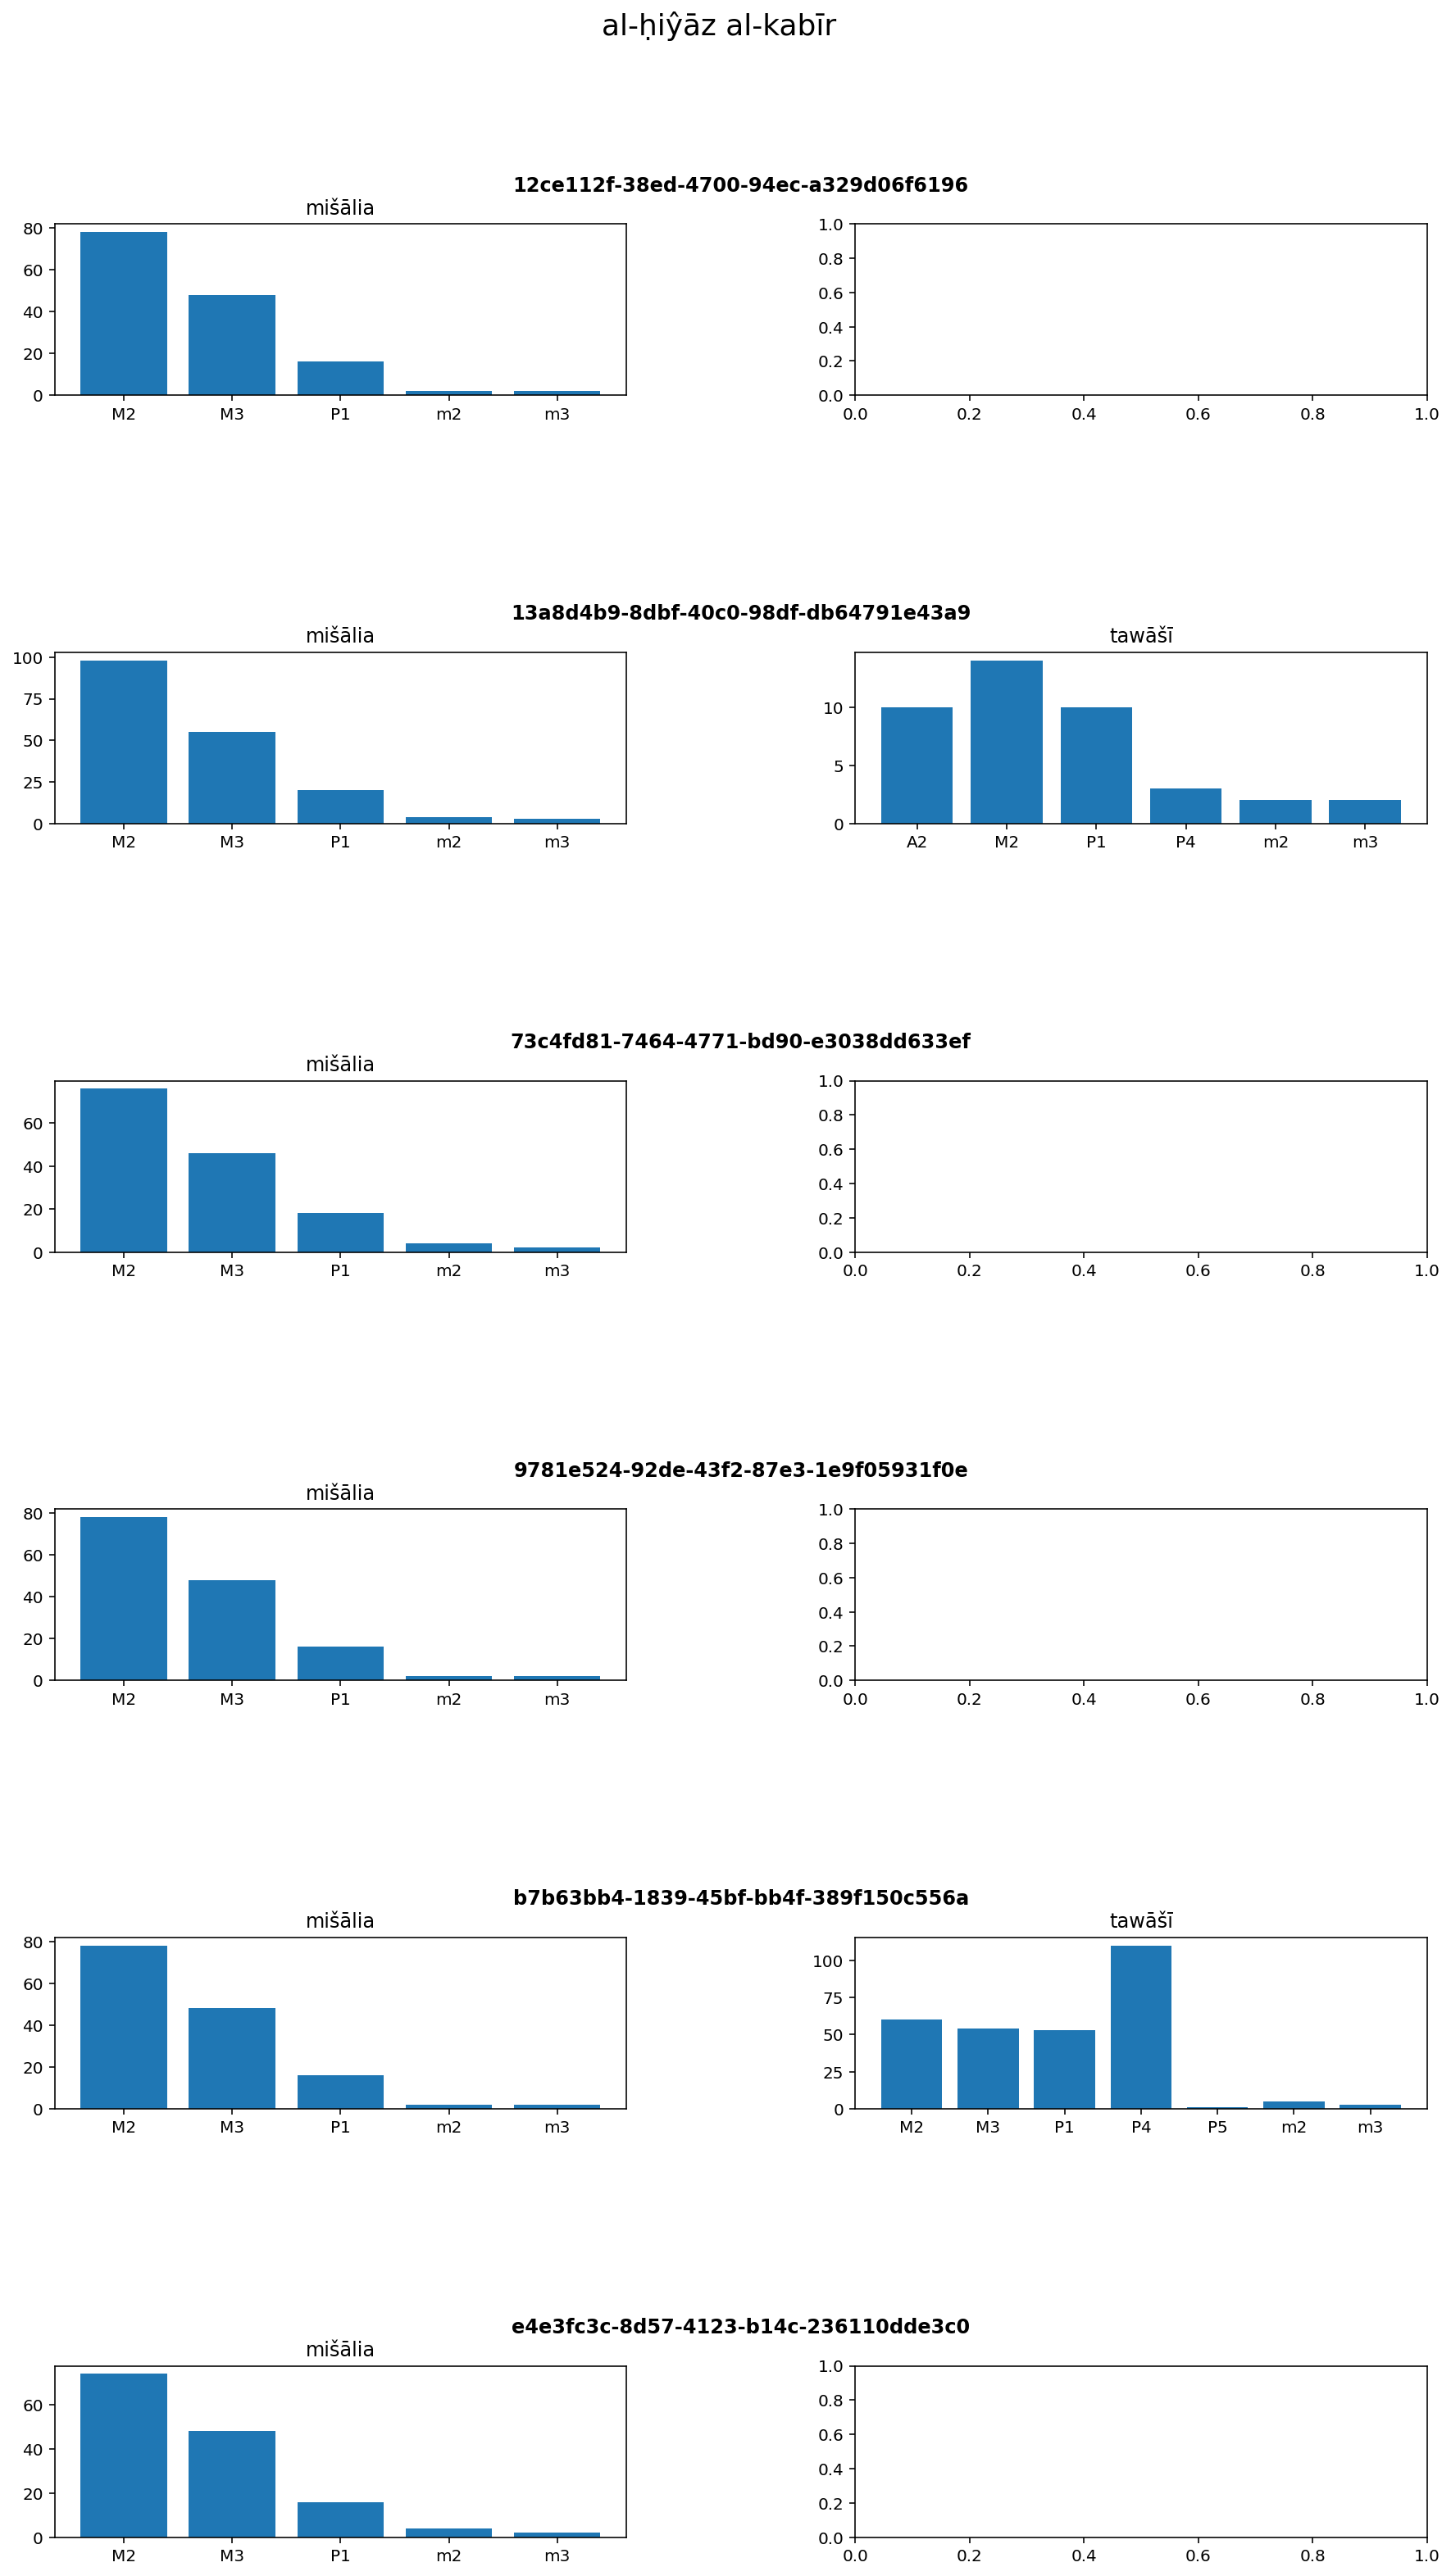

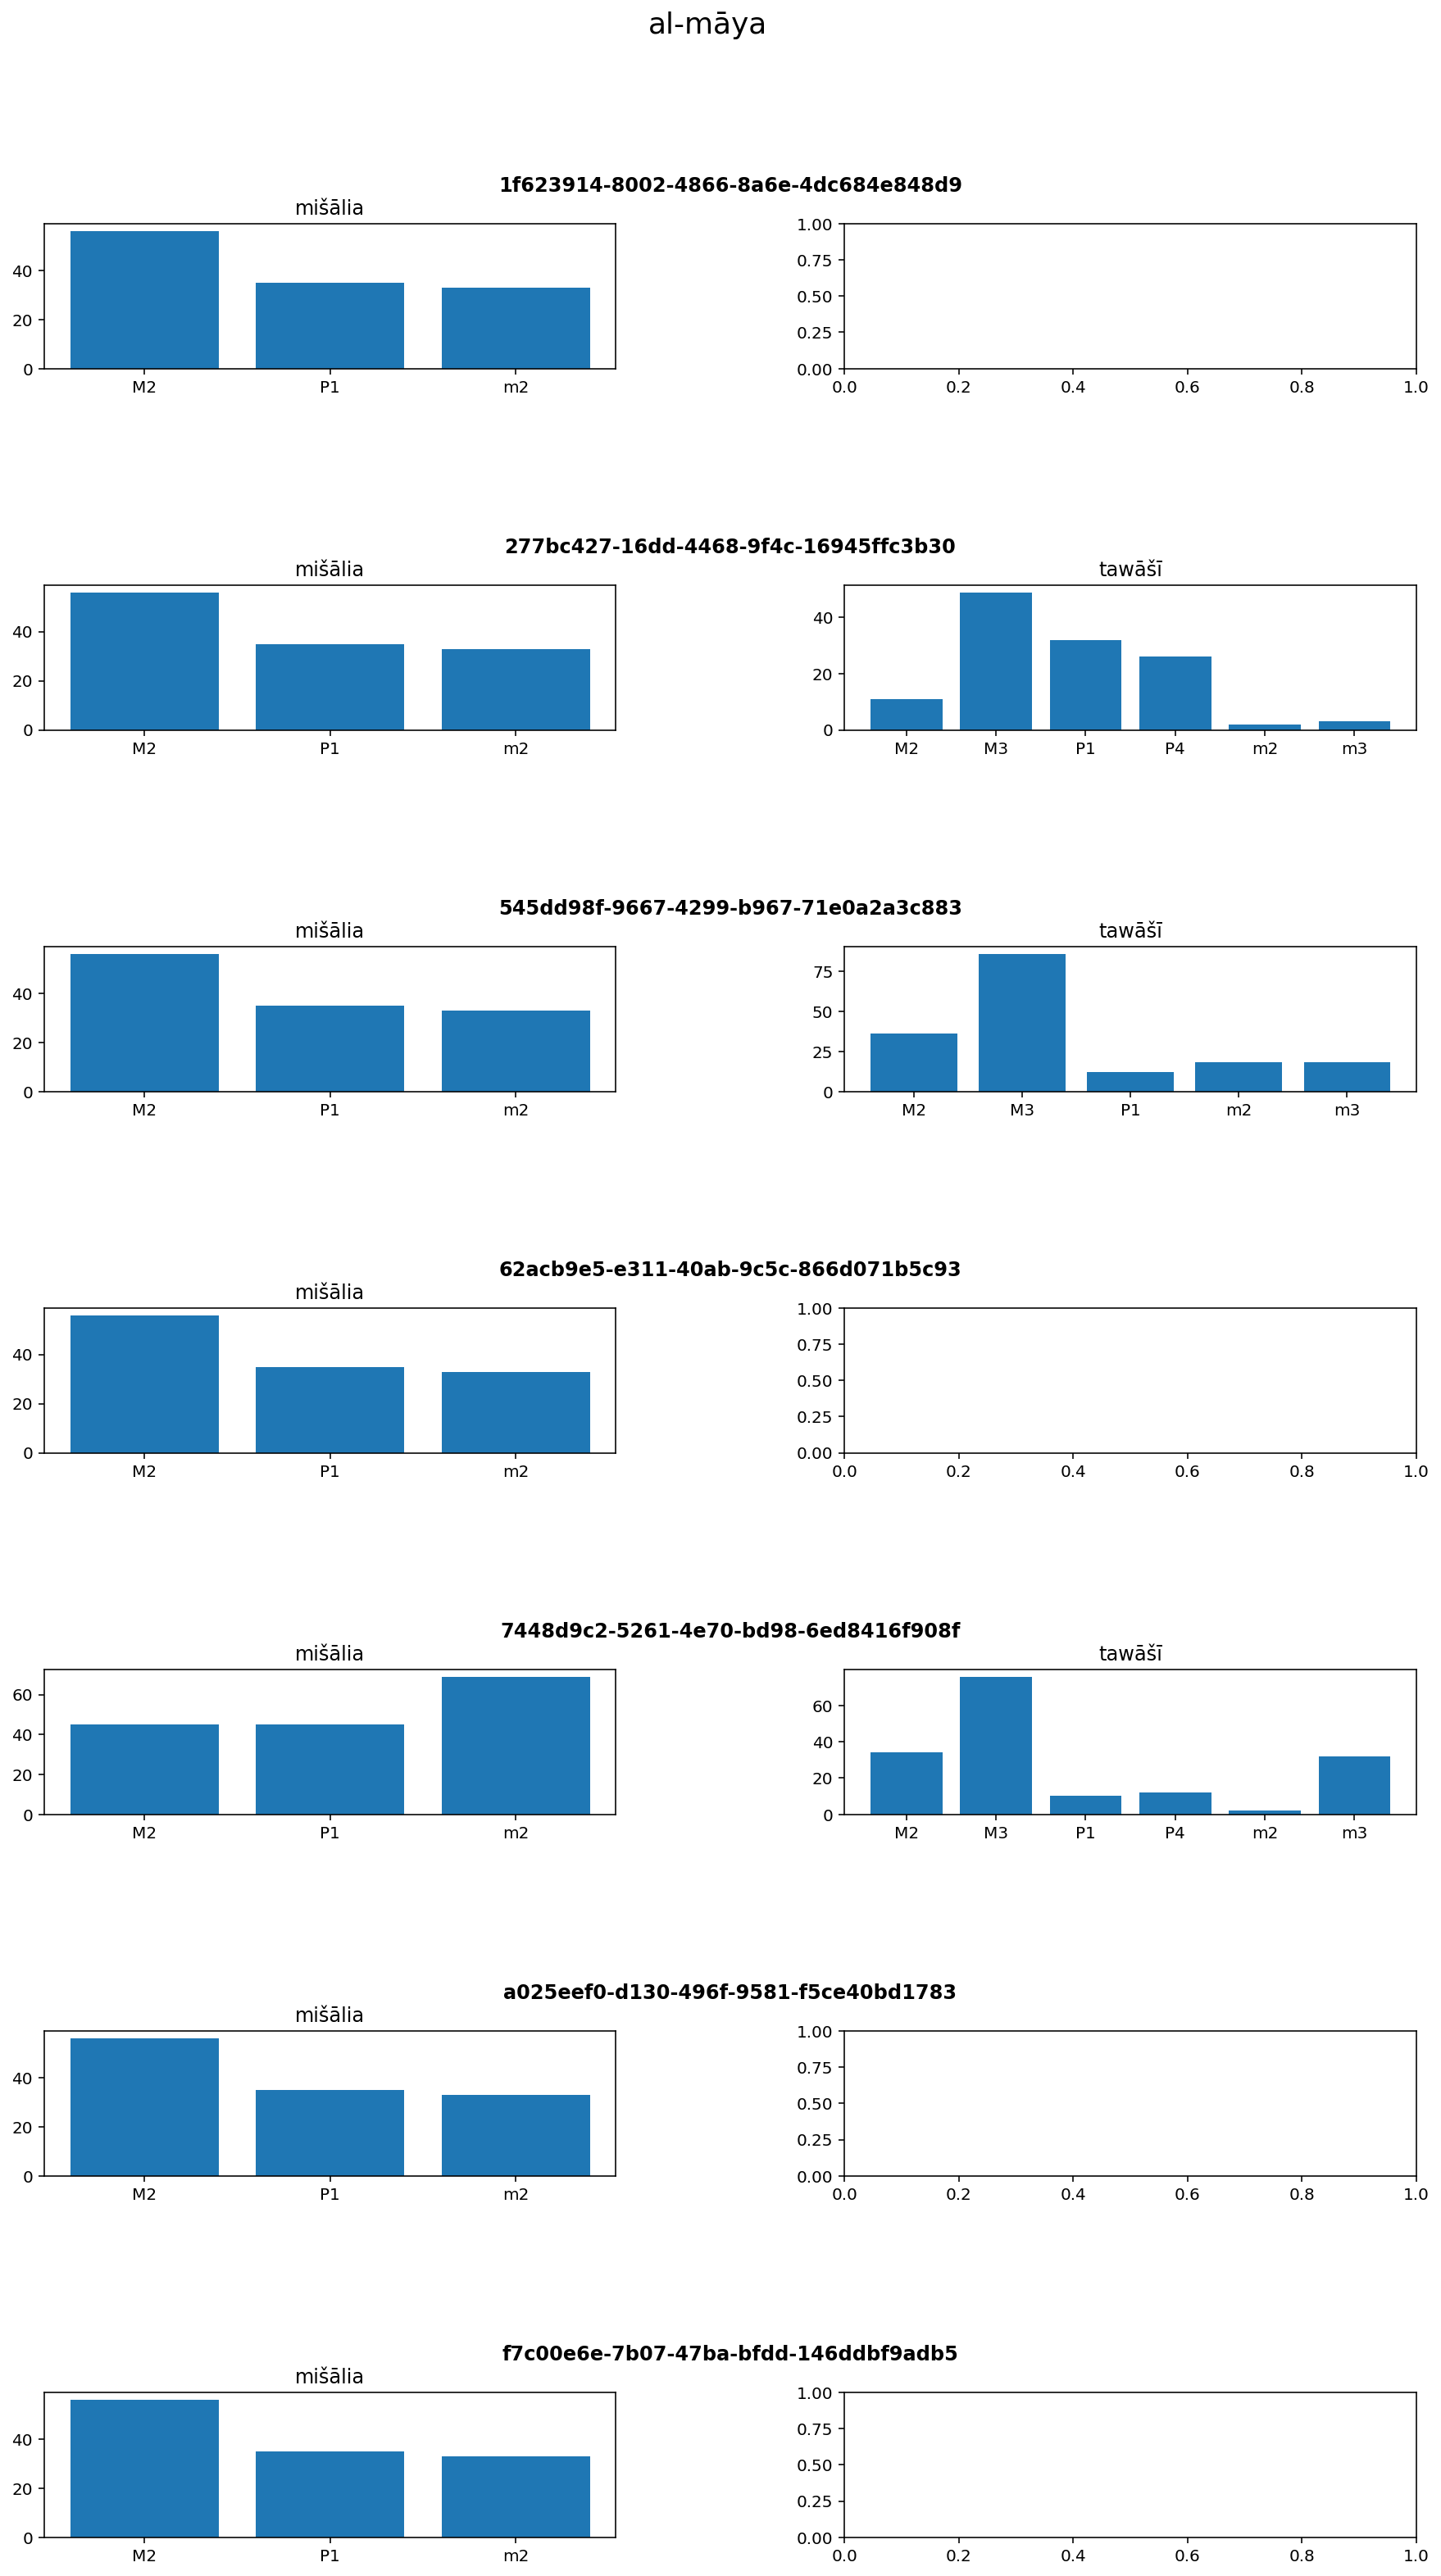

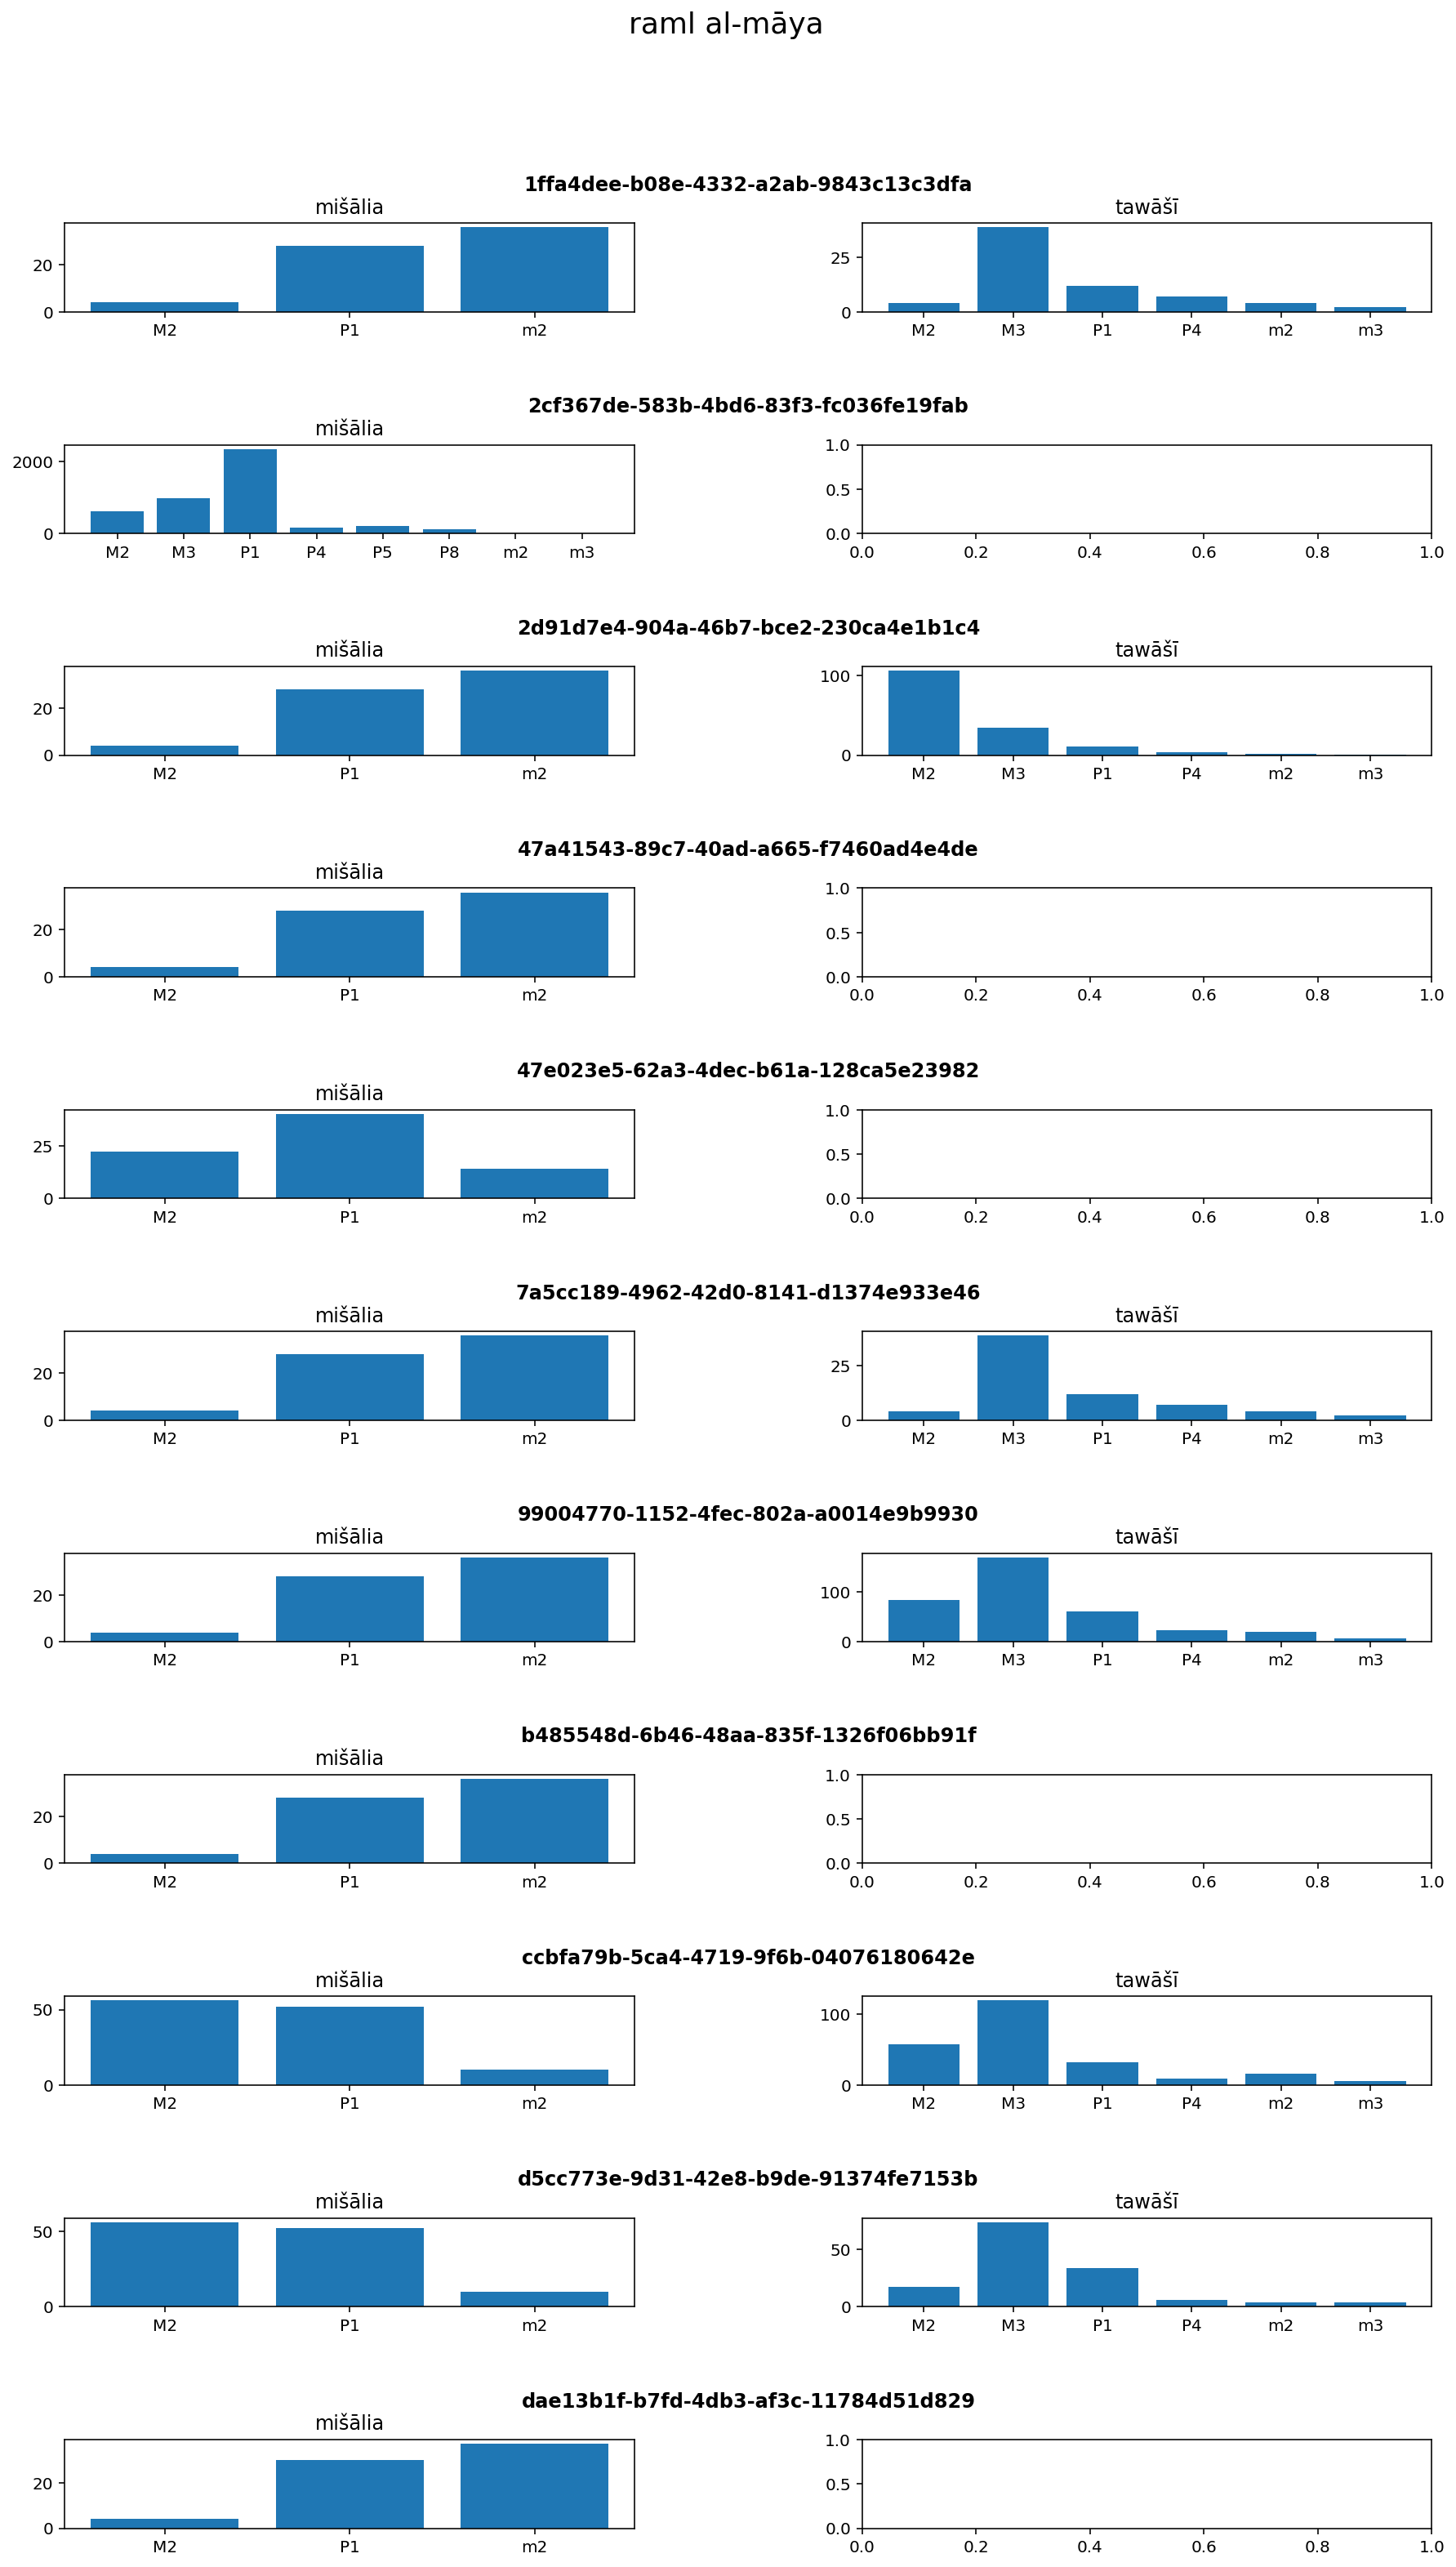

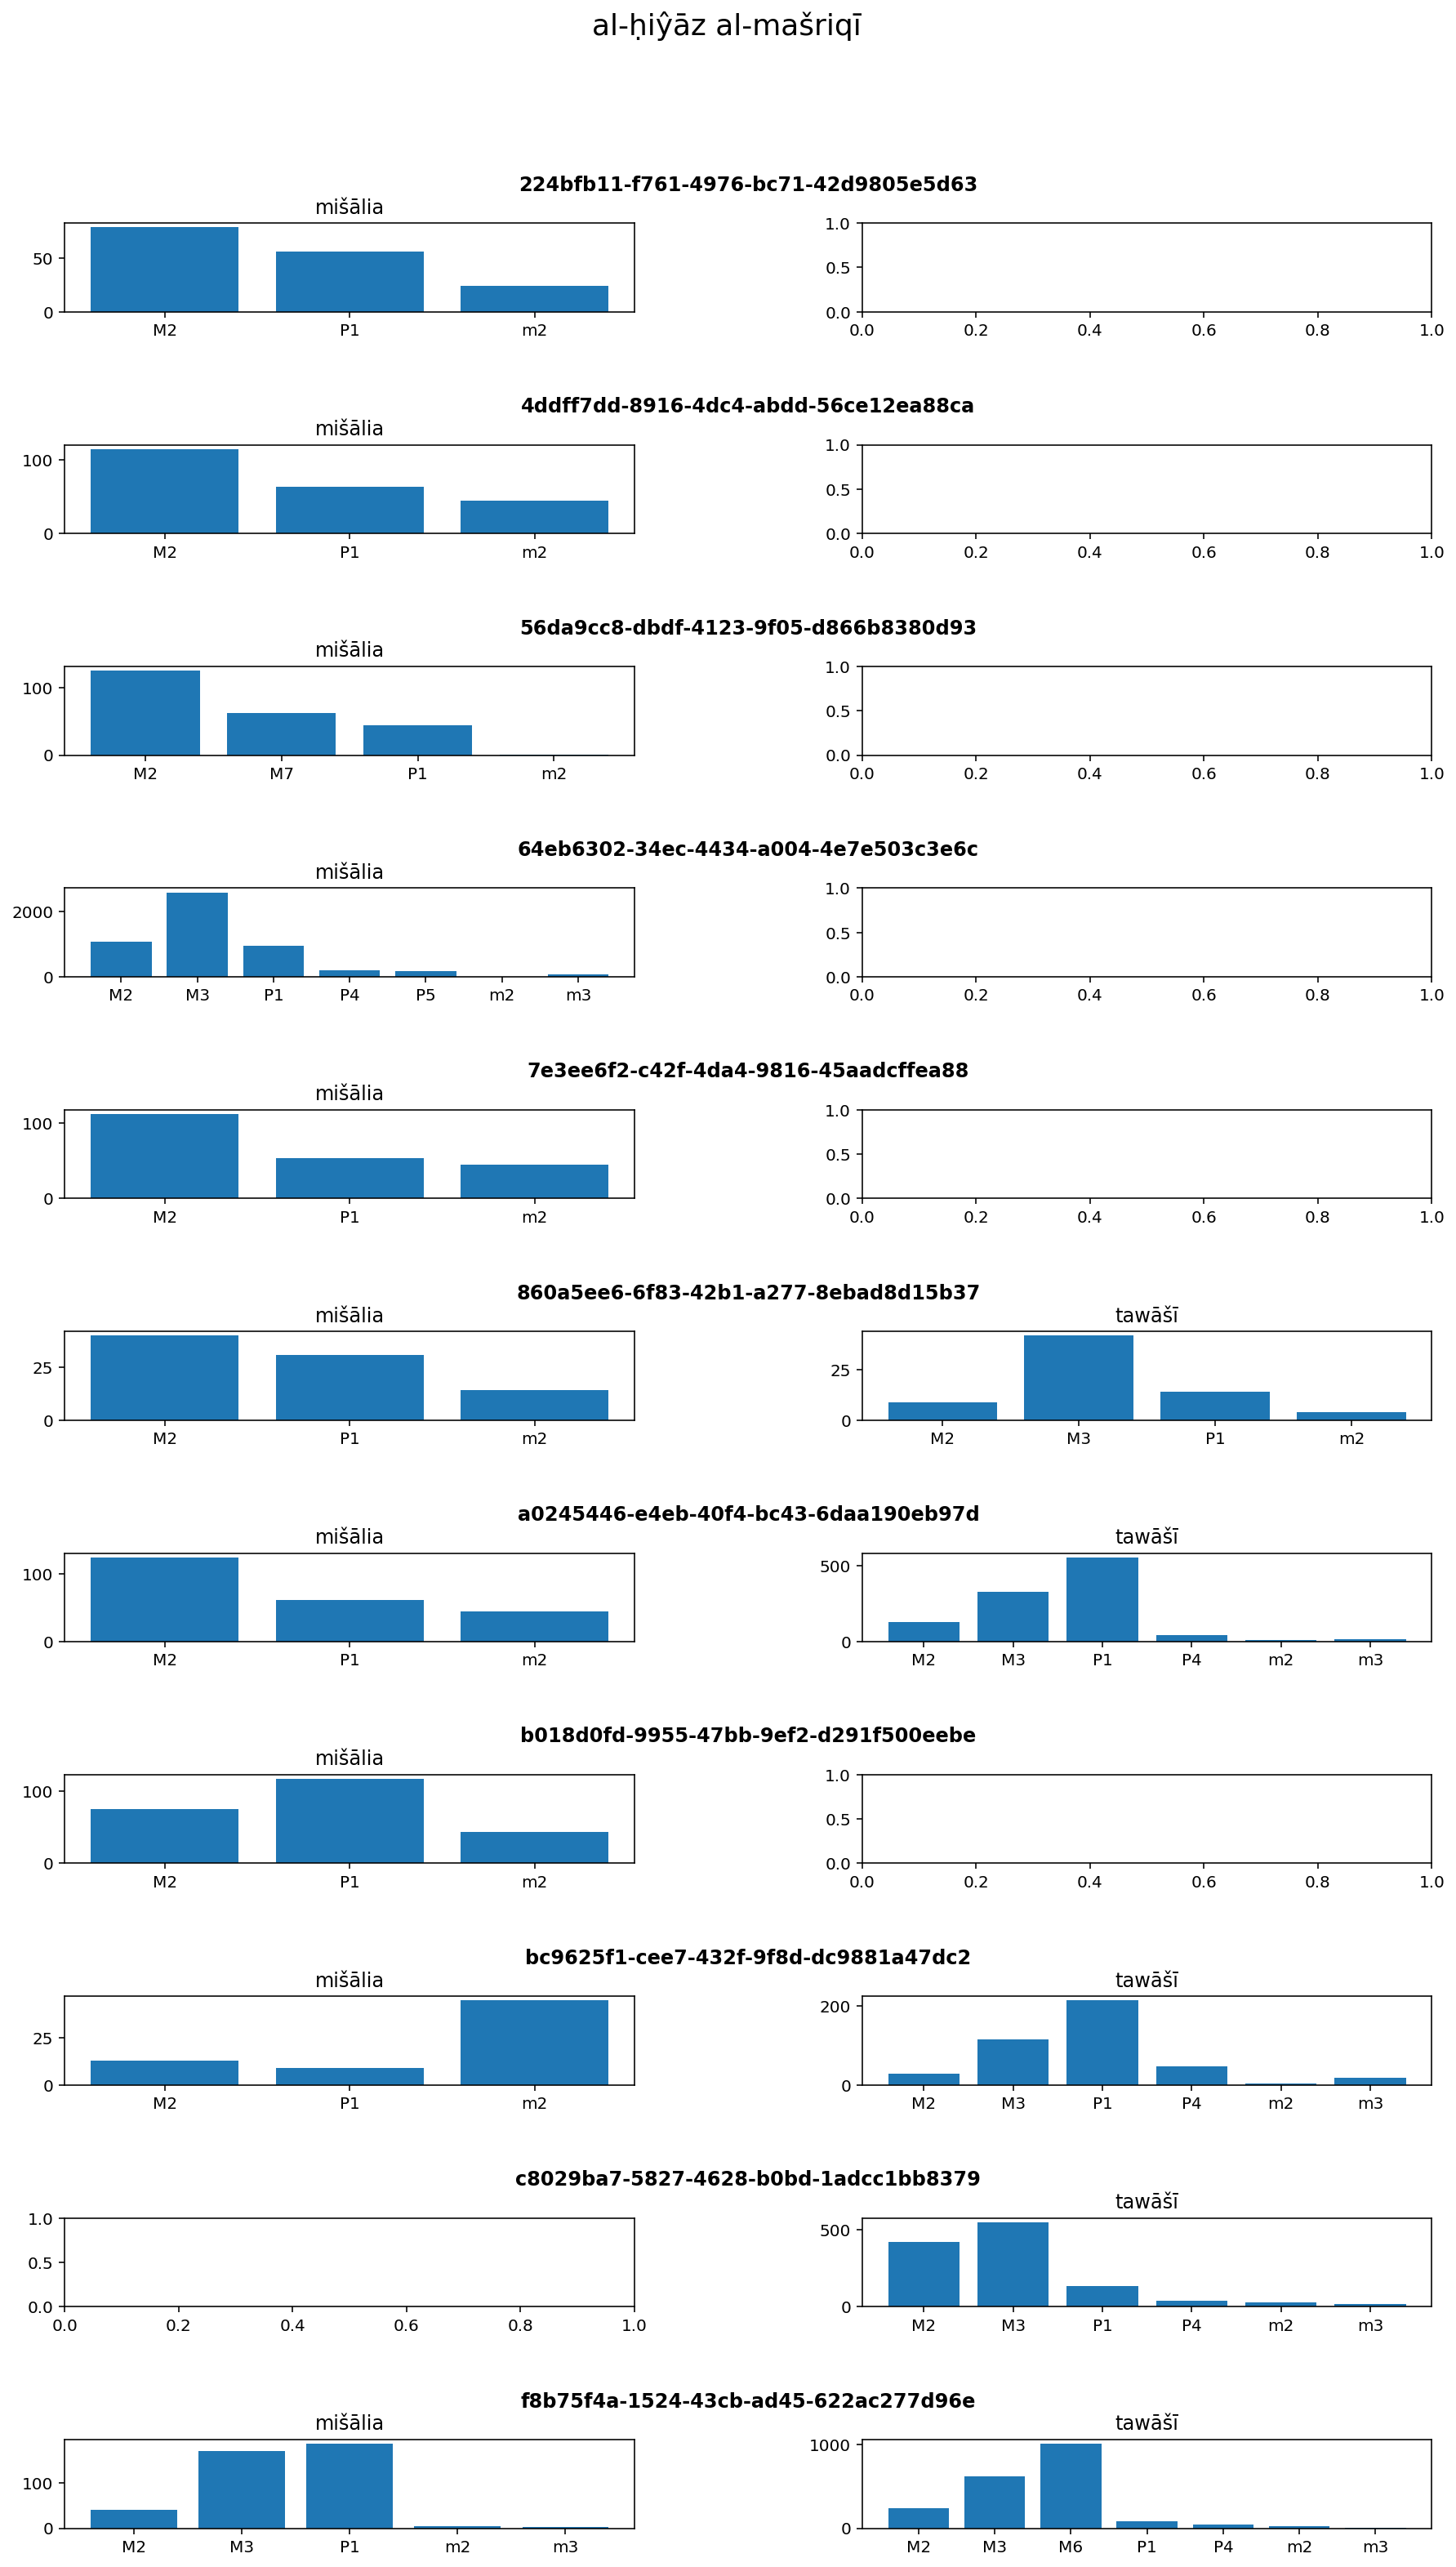

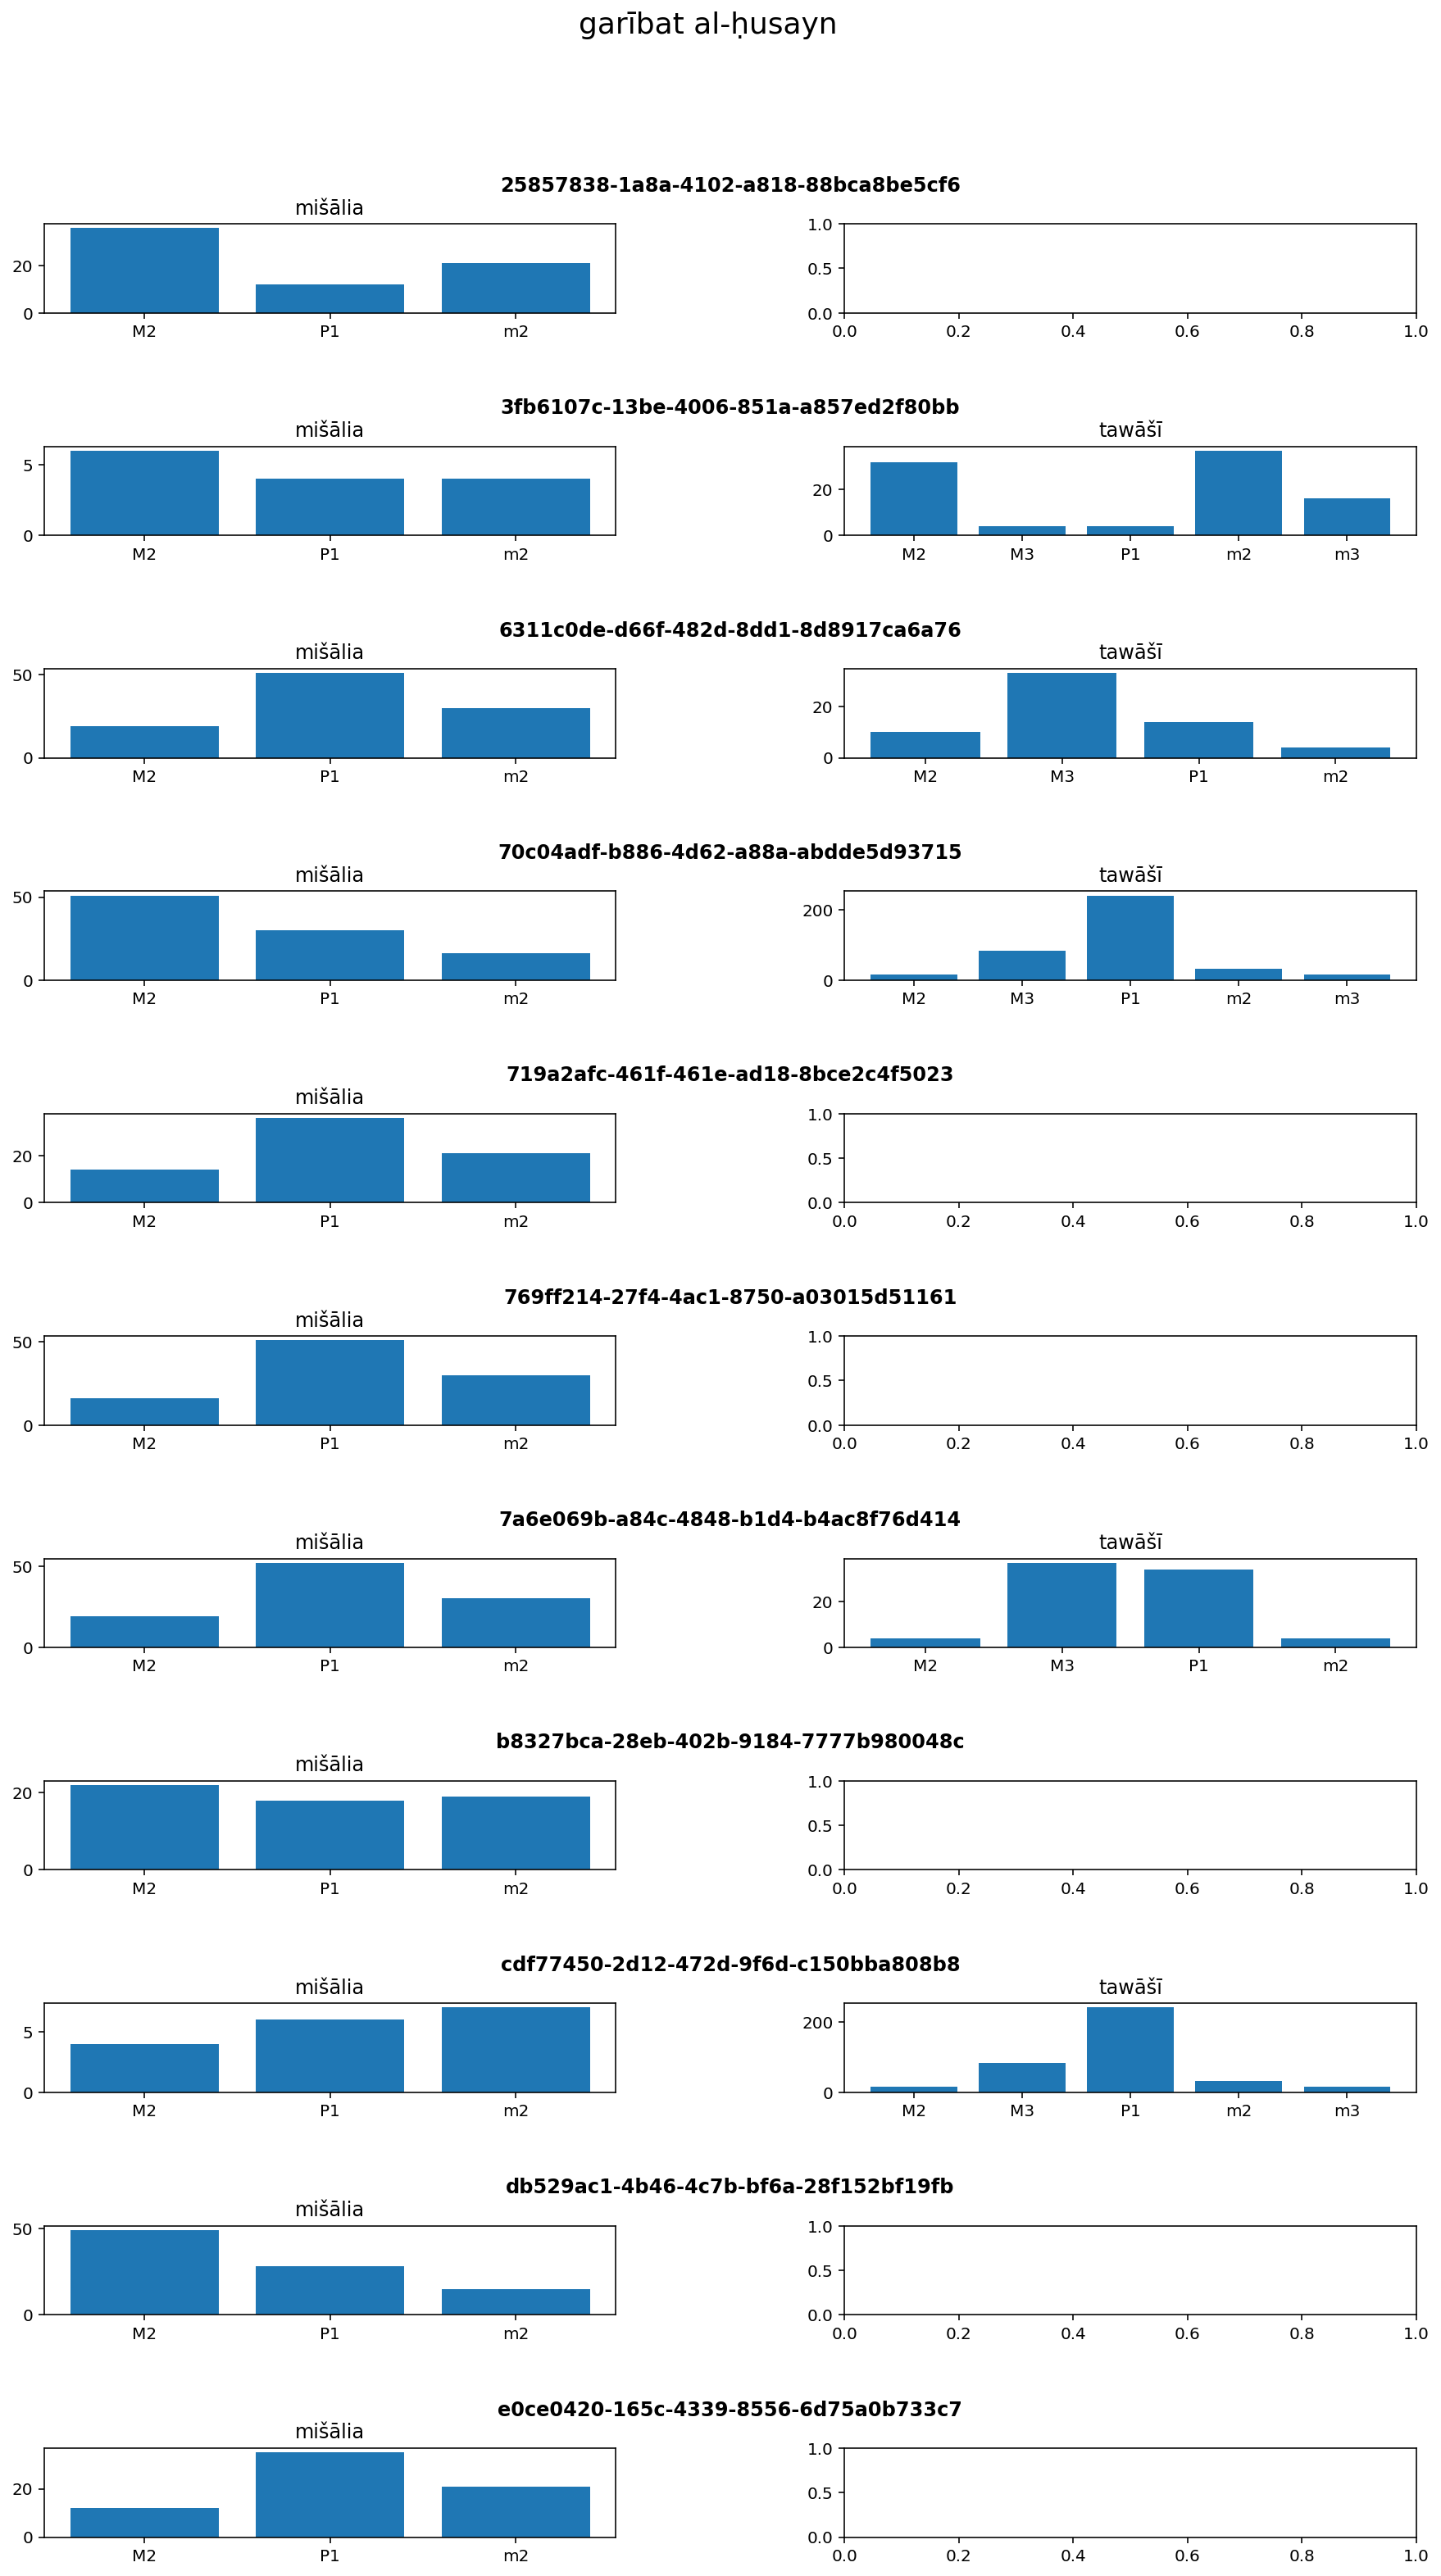

In [46]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import SubplotSpec

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')
       
for nawba in intervals_grouped_by_nawba:
    print('Plotting..%s' %(nawba))
    #Prepare Subplot
    fig, axs = plt.subplots(len(intervals_grouped_by_nawba[nawba]), 2, figsize=(15,20), gridspec_kw={'width_ratios': [3, 3]})
    fig.suptitle('%s'% (nawba), y=1.08, fontsize=18)
    #fig.tight_layout()
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
    grid = plt.GridSpec(len(intervals_grouped_by_nawba[nawba]), 2)
    
    x = 0
    for mbid in intervals_grouped_by_nawba[nawba].keys():
        create_subtitle(fig, grid[x, ::], mbid)
        for section in intervals_grouped_by_nawba[nawba][mbid].keys():
            x_0 = sorted(intervals_grouped_by_nawba[nawba][mbid][section].keys())
            y_0 = intervals_grouped_by_nawba[nawba][mbid][section].values()
            
            if section == sectionNames[0]:
                axs[x,0].title.set_text(section)
                axs[x,0].bar(x_0, y_0)
            else:
                axs[x,1].bar(x_0, y_0)
                axs[x,1].title.set_text(section)
        x+=1
        
        
    #plt.savefig("interval_plot_{nawba}.png".format(nawba=nawba))